<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">


<h1 align="center", style="margin-bottom: -10px">Предсказание коэффициента восстановления золота из золотосодержащей руды<a class="tocSkip"></h1>
<h4 align="center", style="margin-bottom: 60px">Сборный проект №2, Яндекс Практикум <a class="tocSkip"> </h4>
<h4 align="right", style="margin-bottom: -15px">Исполнитель: Воронин Артём<a class="tocSkip"></h4> 

<h1 align="center">Описание проекта</h1>
<p style="margin-bottom: 30px"></p>
<h2>Задача:<span class="tocSkip"></span></h2>

Компания «Цифры», разрабатывающая решения для эффективной работы промышленных предприятий, предоставила реальные данные с параметрами добычи и очистки золотосодержащей руды с одного из месторождений. Необходимо на основании этих данных подготовить прототип модели машинного обучения для предсказния коэффициента восстановления золота из золотосодержащей руды. Это поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

<p style="margin-bottom: 30px"></p>
<h2> Описание данных:  <span class="tocSkip"></span></h2>

1) Данные состоят из 3 файлов:

- `gold_recovery_train_new.csv` - тренировочные данные;   
- `gold_recovery_test_new.csv` - тестовые данные;     
- `gold_recovery_full_new.csv` - полные сырые данные. 
<p style="margin-bottom: 15px"></p>

Данные индексируются датой и временем получения информации (признак `date`). Соседние по времени параметры часто похожи.  

Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.

2) Расшифровка признаков:
  
- `Rougher feed` — исходное сырье
- `Rougher additions` (или `reagent additions`) — флотационные реагенты: Xanthate, Sulphate, Depressant
- `anthate` — ксантогенат (промотер, или активатор флотации);
- `Sulphate` — сульфат (на данном производстве сульфид натрия);
- `Depressant` — депрессант (силикат натрия).
- `Rougher process` (англ. «грубый процесс») — флотация
- `Rougher tails` — отвальные хвосты
- `Float banks` — флотационная установка
- `Cleaner process` — очистка
- `Rougher Au` — черновой концентрат золота
- `Final Au` — финальный концентрат золота  
Параметры этапов:
- `air amount` — объём воздуха
- `fluid levels` — уровень жидкости
- `feed size` — размер гранул сырья
- `feed rate` — скорость подачи

3) Расшифровка наименования признаков: 

[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag

Возможные значения для блока *этап*:  

rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  

Возможные значения для блока *тип_параметра*:

input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  

# 0 Подготовка к работе

## 0.1 Установка пакетов

In [1]:
!pip install lightgbm --quiet --disable-pip-version-check
!pip install phik --quiet --disable-pip-version-check

## 0.1 Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

import phik
from phik.report import plot_correlation_matrix
from phik import report

from tqdm import tqdm
from copy import deepcopy

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import *
from sklearn.dummy import DummyRegressor

# 1 Открытие файлов и предварительный обзор

## 1.1 Блок описания функций

In [3]:
def data_load(name):
    '''Загружает датасет из файла'''
    
    try:
        data = pd.read_csv(f'/datasets/{name}.csv')
        return data    
    except:
        try:
            data = pd.read_csv(f'https://code.s3.yandex.net/datasets/{name}.csv')
            return data
        except:  
            print(f'Ошибка месторасположения csv-файла "{name}"')

In [4]:
def pass_value_barh(df):
    '''Строит гистограмму пропусков и их долю в %'''
    
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by='space', ascending=True)
            .plot(kind='barh', figsize=(15, 30), legend=False, fontsize=14)
            .set_title('Гистограмма пропусков' + "\n", fontsize=22, color='SteelBlue')    
        );   
        print('\nДоля пропусков: {:.2%}'.format(df.isna().mean().mean()))
    except:
        plt.close();
        print('Пропусков нет 😎')

## 1.2 Обучающая выборка

In [5]:
train = data_load('gold_recovery_train_new')

train.info()
print()
display(train.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   
2              0.953716              16.208849              2.257889  ...   
3              0.883763              16.532835              2.146849  ...   
4              0.792826              16.525686              2.055292  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   
2                                 14.015015   
3                                 14.036510   
4                                 14.027298   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -502.488007   
1                                 -505.503262   
2                                 -502.520901   
3                                 -500.857308   
4                                 -499.838632   

   secondary_cleaner.state.floatbank4_b_air  \
0                                 12.099931   
1                                 11.950531   
2                                 11.912783   
3                                 11.999550   
4                                 11.953070   

   secondary_cleaner.state.floatbank4_b_level  \
0                                 -504.715942   
1                                 -501.331529   
2                                 -501.133383   
3                                 -501.193686   
4                                 -501.053894   

   secondary_cleaner.state.floatbank5_a_air  \
0                                  9.925633   
1                                 10.039245   
2                                 10.070913   
3                                  9.970366   
4                                  9.925709   

   secondary_cleaner.state.floatbank5_a_level  \
0                                 -498.310211   
1                                 -500.169983   
2                                 -500.129135   
3                                 -499.201640   
4                                 -501.686727   

   secondary_cleaner.state.floatbank5_b_air  \
0                                  8.079666   
1                                  7.984757   
2                                  8.013877   
3                                  7.977324   
4                                  7.894242   

   secondary_cleaner.state.floatbank5_b_level  \
0                                 -500.470978   
1                                 -500.582168   
2                                 -500.517572   
3                                 -500.255908   
4                                 -500.356035   

   secondary_cleaner.state.floatbank6_a_air  \
0    

### Проверка расчета эффективности обогащения

Эффективность обогащения рассчитывается по формуле:

$$
Recovery = \frac{C * (F - T)}{F * (C - T)} * 100\%
$$

где:  
C — доля золота в концентрате после флотации/очистки;  
F — доля золота в сырье/концентрате до флотации/очистки;  
T — доля золота в отвальных хвостах после флотации/очистки. 

Для прогноза коэффициента нужно найти долю золота в концентратах и хвостах. Причём важен не только финальный продукт, но и черновой концентрат.

In [6]:
c = train['rougher.output.concentrate_au']
f = train['rougher.input.feed_au']
t = train['rougher.output.tail_au']

recovery_check = (c * (f - t)) / (f * (c - t)) * 100

mean_absolute_error(train['rougher.output.recovery'], recovery_check)

9.73512347450521e-15

**Вывод**: 

Значение средней абсолютной ошибки ничтожно мало. Это говорит о том, что эфективность обогащения расчитана правильно.

## 1.2 Тестовая выборка

In [7]:
test = data_load('gold_recovery_test_new')

test.info()
print()
display(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

date  primary_cleaner.input.sulfate  \
0  2016-09-01 00:59:59                     210.800909   
1  2016-09-01 01:59:59                     215.392455   
2  2016-09-01 02:59:59                     215.259946   
3  2016-09-01 03:59:59                     215.336236   
4  2016-09-01 04:59:59                     199.099327   

   primary_cleaner.input.depressant  primary_cleaner.input.feed_size  \
0                         14.993118                         8.080000   
1                         14.987471                         8.080000   
2                         12.884934                         7.786667   
3                         12.006805                         7.640000   
4                         10.682530                         7.530000   

   primary_cleaner.input.xanthate  primary_cleaner.state.floatbank8_a_air  \
0                        1.005021                             1398.981301   
1                        0.990469                             1398.777912   
2                        0.996043                             1398.493666   
3                        0.863514                             1399.618111   
4                        0.805575                             1401.268123   

   primary_cleaner.state.floatbank8_a_level  \
0                               -500.225577   
1                               -500.057435   
2                               -500.868360   
3                               -498.863574   
4                               -500.808305   

   primary_cleaner.state.floatbank8_b_air  \
0                             1399.144926   
1                             1398.055362   
2                             1398.860436   
3                             1397.440120   
4                             1398.128818   

   primary_cleaner.state.floatbank8_b_level  \
0                               -499.919735   
1                               -499.778182   
2                               -499.764529   
3                               -499.211024   
4                               -499.504543   

   primary_cleaner.state.floatbank8_c_air  ...  \
0                             1400.102998  ...   
1                             1396.151033  ...   
2                             1398.075709  ...   
3                             1400.129303  ...   
4                             1402.172226  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 12.023554   
1                                 12.058140   
2                                 11.962366   
3                                 12.033091   
4                                 12.025367   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -497.795834   
1                                 -498.695773   
2                                 -498.767484   
3                                 -498.350935   
4                                 -500.786497   

   secondary_cleaner.state.floatbank4_b_air  \
0                                  8.016656   
1                                  8.130979   
2                                  8.096893   
3                                  8.074946   
4                                  8.054678   

   secondary_cleaner.state.floatbank4_b_level  \
0                                 -501.289139   
1                                 -499.634209   
2                                 -500.827423   
3                                 -499.474407   
4                                 -500.397500   

   secondary_cleaner.state.floatbank5_a_air  \
0                                  7.946562   
1                                  7.958270   
2                                  8.071056   
3                                  7.897085   
4                                  8.107890   

   secondary_cleaner.state.floatbank5_a_level  \
0                                 -432.317850   
1                                 -525.839648   
2                                 -500.801673   
3     

### Анализ признаков тестовой выборки


In [8]:
set(train.columns) - set(test.columns)

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

**Вывод:** 

В тестовой выборке отсутствуют следующие признаки:

+ `final.output` 
+ `primary_cleaner.output`
+ `secondary_cleaner.output`
+ `rougher.output` 
+ `rougher.calculation`   

Признаки "output" являются параметрами выходного продукта. Т.е. в выборке отсутствуют выходные данные после каждого этапа обработки, а так же расчетные хар-ки "calculation".  Их невозможно получить, либо замерить во время выполнения технологического процесса. Два из них нужно спрогнозировать - `rougher.output.recovery` и `final.output.recovery`.

## 1.3 Полная выборка

In [9]:
full = data_load('gold_recovery_full_new')

full.info()
print()
display(full.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


date  final.output.concentrate_ag  \
0  2016-01-15 00:00:00                     6.055403   
1  2016-01-15 01:00:00                     6.029369   
2  2016-01-15 02:00:00                     6.055926   
3  2016-01-15 03:00:00                     6.047977   
4  2016-01-15 04:00:00                     6.148599   

   final.output.concentrate_pb  final.output.concentrate_sol  \
0                     9.889648                      5.507324   
1                     9.968944                      5.257781   
2                    10.213995                      5.383759   
3                     9.977019                      4.858634   
4                    10.142511                      4.939416   

   final.output.concentrate_au  final.output.recovery  final.output.tail_ag  \
0                    42.192020              70.541216             10.411962   
1                    42.701629              69.266198             10.462676   
2                    42.657501              68.116445             10.507046   
3                    42.689819              68.347543             10.422762   
4                    42.774141              66.927016             10.360302   

   final.output.tail_pb  final.output.tail_sol  final.output.tail_au  ...  \
0              0.895447              16.904297              2.143149  ...   
1              0.927452              16.634514              2.224930  ...   
2              0.953716              16.208849              2.257889  ...   
3              0.883763              16.532835              2.146849  ...   
4              0.792826              16.525686              2.055292  ...   

   secondary_cleaner.state.floatbank4_a_air  \
0                                 14.016835   
1                                 13.992281   
2                                 14.015015   
3                                 14.036510   
4                                 14.027298   

   secondary_cleaner.state.floatbank4_a_level  \
0                                 -502.488007   
1                                 -505.503262   
2                                 -502.520901   
3                                 -500.857308   
4                                 -499.838632   

   secondary_cleaner.state.floatbank4_b_air  \
0                                 12.099931   
1                                 11.950531   
2                                 11.912783   
3                                 11.999550   
4                                 11.953070   

   secondary_cleaner.state.floatbank4_b_level  \
0                                 -504.715942   
1                                 -501.331529   
2                                 -501.133383   
3                                 -501.193686   
4                                 -501.053894   

   secondary_cleaner.state.floatbank5_a_air  \
0                                  9.925633   
1                                 10.039245   
2                                 10.070913   
3                                  9.970366   
4                                  9.925709   

   secondary_cleaner.state.floatbank5_a_level  \
0                                 -498.310211   
1                                 -500.169983   
2                                 -500.129135   
3                                 -499.201640   
4                                 -501.686727   

   secondary_cleaner.state.floatbank5_b_air  \
0                                  8.079666   
1                                  7.984757   
2                                  8.013877   
3                                  7.977324   
4                                  7.894242   

   secondary_cleaner.state.floatbank5_b_level  \
0                                 -500.470978   
1                                 -500.582168   
2                                 -500.517572   
3                                 -500.255908   
4                                 -500.356035   

   secondary_cleaner.state.floatbank6_a_air  \
0    

**Вывод:**

Данные содержат 87 признаков. Пропуски имеются во всех 3 датасетах (более детально рассмотрим ниже). Предположительно train и test это выборки из full датасета.

# 2 Предобработка данных

## 2.1 Обучающая выборка

**Дубликаты**

In [10]:
train.duplicated().sum()

0

Явных дубликатов нет. Посмотрим есть ли дубликаты записей по времени:

In [11]:
train.duplicated(subset='date').sum()

0

Дубликатов объектов по времени тоже нет.

**Пропуски**


Доля пропусков: 0.33%


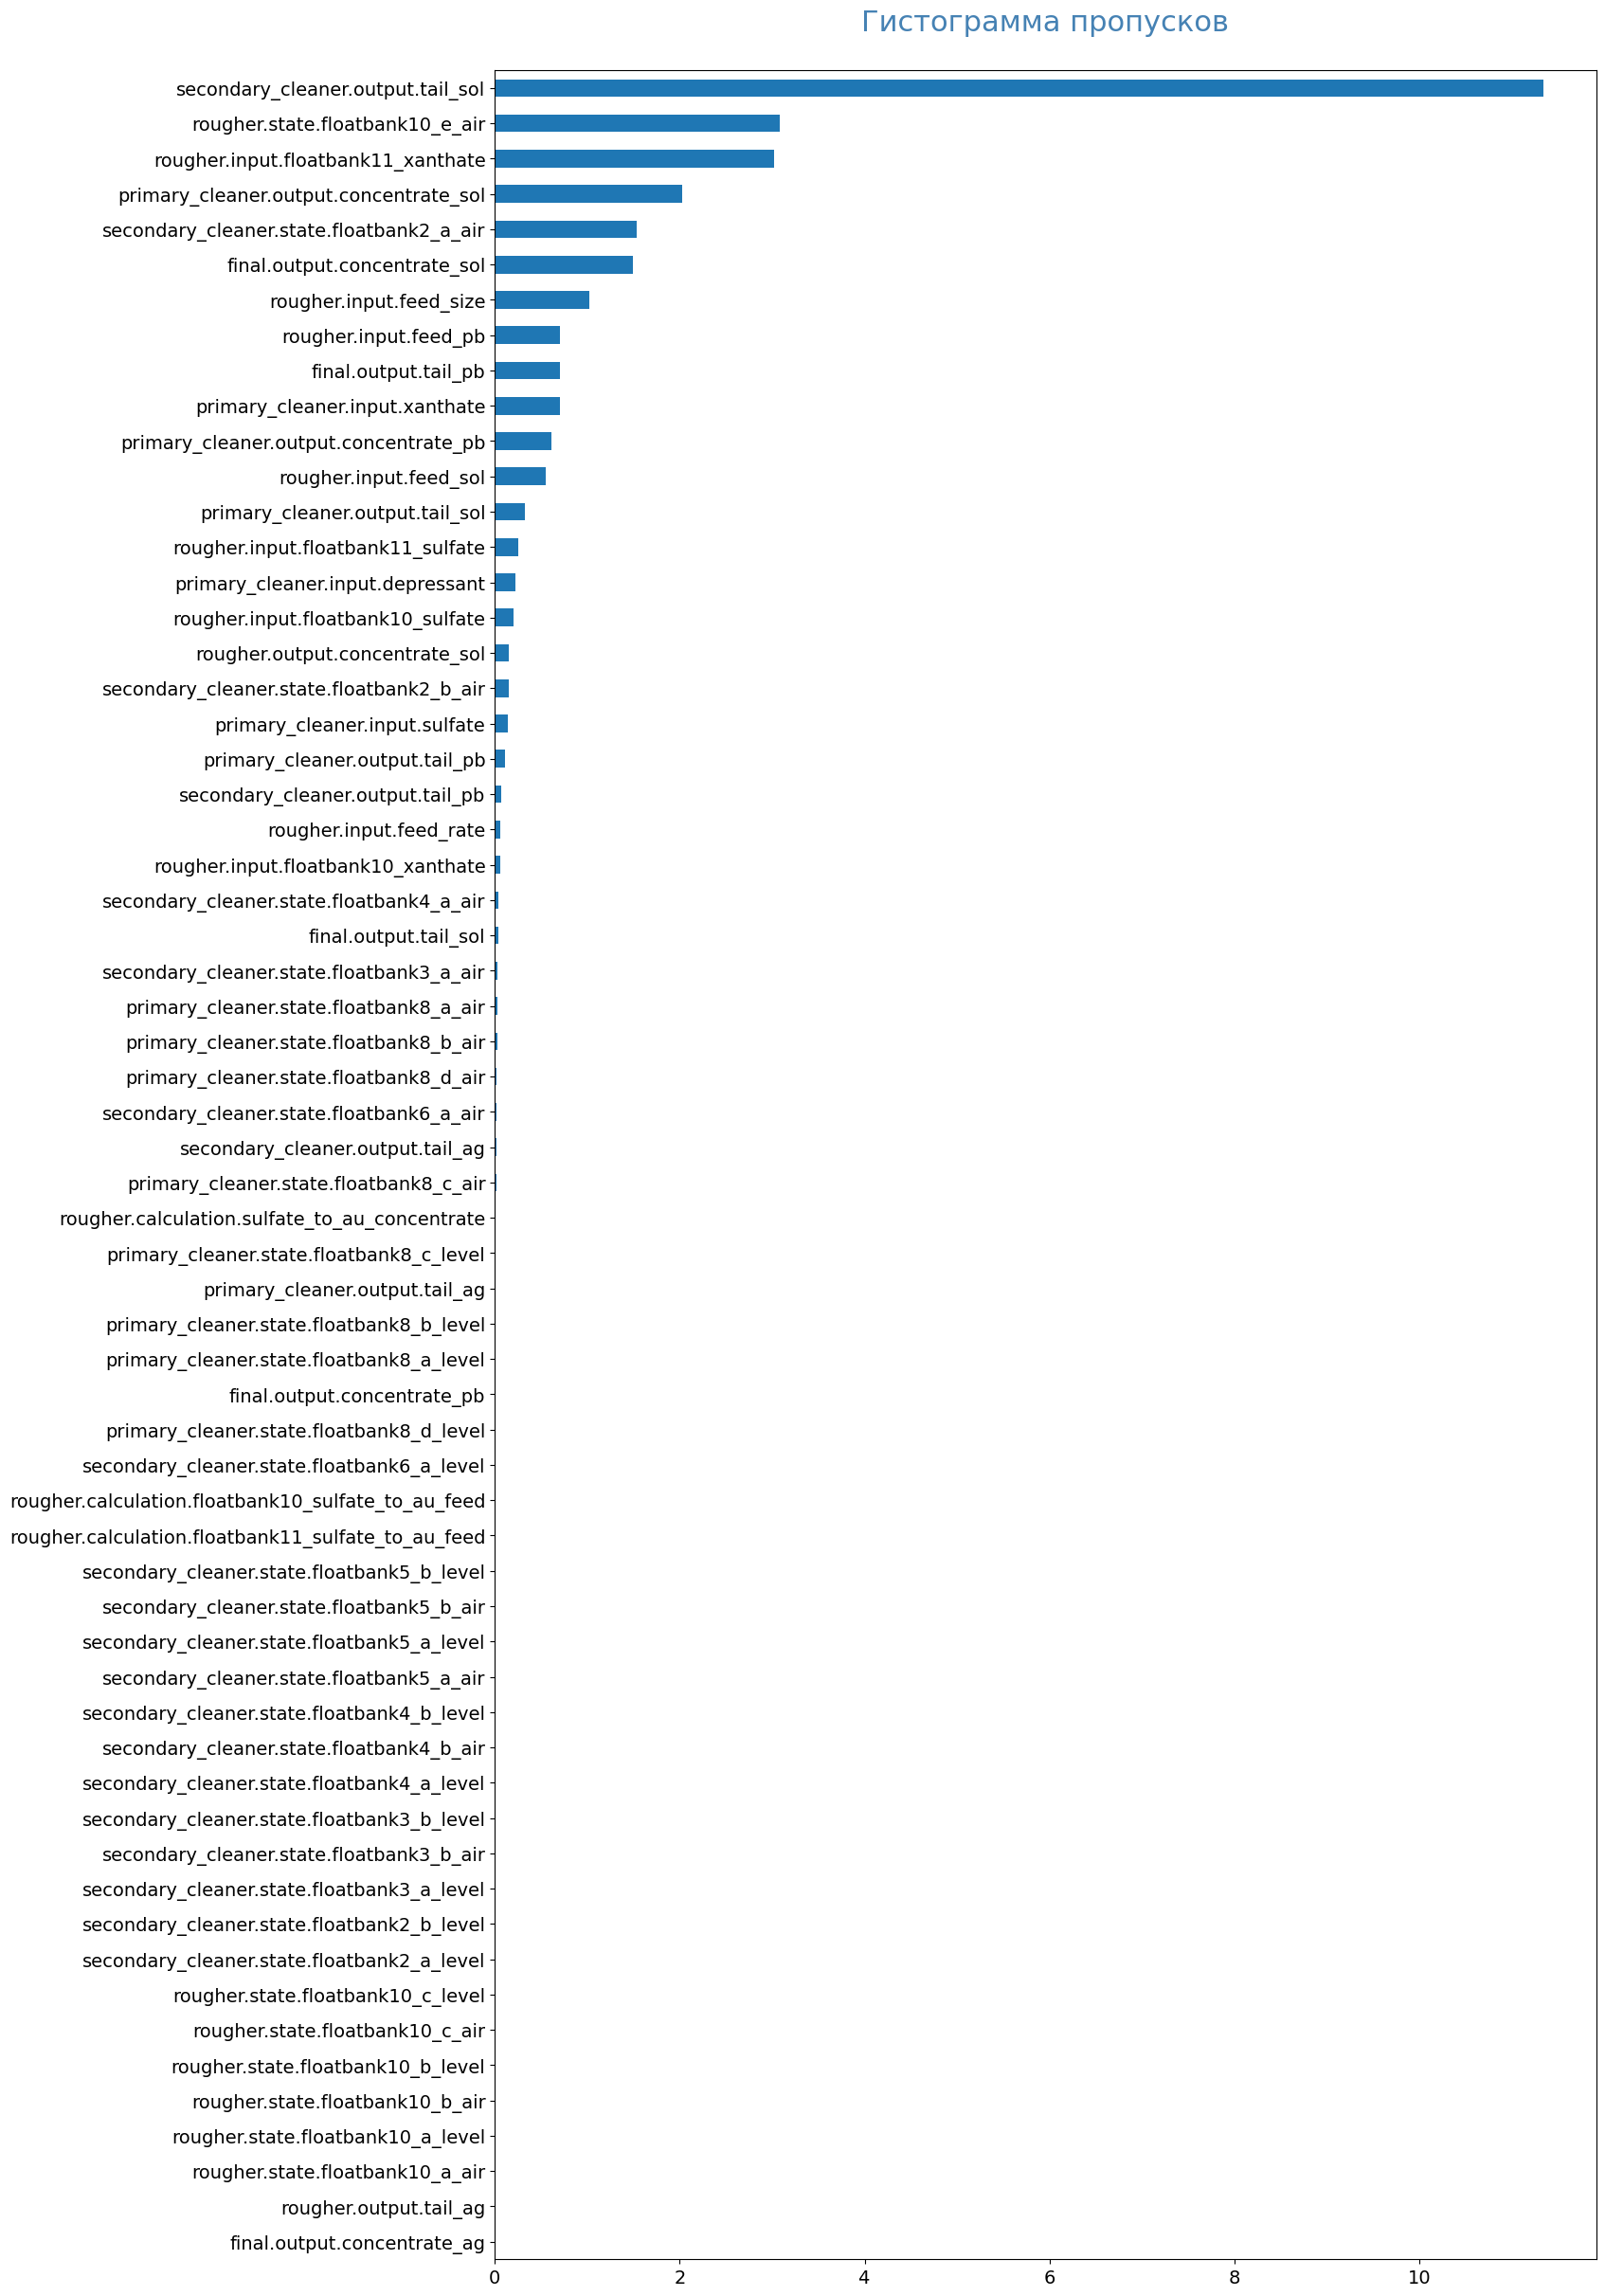

In [12]:
pass_value_barh(train)

Заменим пропуски в данных, взяв их из full выборки.

In [13]:
train_na = train.loc[ train.isna().any(axis=1).values,     # выборка с пропусками
                       train.isna().any().values  ]          

for i in train_na:
    for j in train_na.index:
        if train.loc[j, i] != train.loc[j, i]:
            train.loc[j, i] = full.loc[j, i]            

In [14]:
train.isna().sum().sum()

817

Удалось заменить около 80% пропусков. Обработаем оставшиеся пропуски искусственными методами.

Размер датасета до обработки:

In [15]:
train.shape

(14149, 87)

Для начала удалим из датасета объекты, в которых пропущено более 5% признаков:

In [16]:
train.dropna(thresh=round(train.shape[1] * 0.95), inplace=True)
train.shape

(14143, 87)

Из датасета удалилось 6 объектов.

Т.к. известно, что "*Соседние по времени параметры часто похожи*", то замену оставшихся пропусков произведем на смежное (предыдущее) значение. На всякий случай отсортируем таблицу по столбцу `date`:

In [17]:
train = train.sort_values(by='date').fillna(method='ffill')
train.isna().sum().sum()    # check

0

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14143 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14143 non-null  object 
 1   final.output.concentrate_ag                         14143 non-null  float64
 2   final.output.concentrate_pb                         14143 non-null  float64
 3   final.output.concentrate_sol                        14143 non-null  float64
 4   final.output.concentrate_au                         14143 non-null  float64
 5   final.output.recovery                               14143 non-null  float64
 6   final.output.tail_ag                                14143 non-null  float64
 7   final.output.tail_pb                                14143 non-null  float64
 8   final.output.tail_sol                               14143 non-null  float64


In [19]:
train.describe().round()

final.output.concentrate_ag  final.output.concentrate_pb  \
count                      14143.0                      14143.0   
mean                           5.0                         10.0   
std                            1.0                          2.0   
min                            0.0                          0.0   
25%                            4.0                          9.0   
50%                            5.0                         10.0   
75%                            6.0                         11.0   
max                           16.0                         17.0   

       final.output.concentrate_sol  final.output.concentrate_au  \
count                       14143.0                      14143.0   
mean                            9.0                         44.0   
std                             3.0                          5.0   
min                             0.0                          0.0   
25%                             7.0                         43.0   
50%                             9.0                         45.0   
75%                            10.0                         46.0   
max                            18.0                         53.0   

       final.output.recovery  final.output.tail_ag  final.output.tail_pb  \
count                14143.0               14143.0               14143.0   
mean                    67.0                  10.0                   3.0   
std                     10.0                   2.0                   1.0   
min                      0.0                   0.0                   0.0   
25%                     63.0                   8.0                   2.0   
50%                     67.0                   9.0                   3.0   
75%                     72.0                  11.0                   3.0   
max                    100.0                  20.0                   6.0   

       final.output.tail_sol  final.output.tail_au  \
count                14143.0               14143.0   
mean                    11.0                   3.0   
std                      3.0                   1.0   
min                      0.0                   0.0   
25%                      9.0                   2.0   
50%                     11.0                   3.0   
75%                     12.0                   3.0   
max                     22.0                   8.0   

       primary_cleaner.input.sulfate  ...  \
count                        14143.0  ...   
mean                           133.0  ...   
std                             39.0  ...   
min                              0.0  ...   
25%                            107.0  ...   
50%                            133.0  ...   
75%                            160.0  ...   
max                            250.0  ...   

       secondary_cleaner.state.floatbank4_a_air  \
count                                   14143.0   
mean                                       20.0   
std                                         6.0   
min                                         0.0   
25%                                        15.0   
50%                                        20.0   
75%                                        25.0   
max                                        30.0   

       secondary_cleaner.state.floatbank4_a_level  \
count                                     14143.0   
mean                                       -479.0   
std                                          51.0   
min                                        -800.0   
25%                                        -501.0   
50%                                        -500.0   
75%                                        -478.0   
max                                        -245.0   

       secondary_cleaner.state.floatbank4_b_air  \
count                                   14143.0   
mean                                       15.0   
std                                         5.0   
min                                         0.0   
25%                

## 2.2 Тестовая выборка

Кол-во пропусков в датасете:

In [20]:
test.isna().sum().sum()

90

В модель необходимо подавать данные без пропусков. Их кол-во мало, удалим их:

In [21]:
test.dropna(inplace=True)

test.isna().sum().sum()   # check

0

# 3 Исследовательский анализ данных

In [22]:
color = ['r', 'b', 'g', 'y', 'm', 'c', 'k']    # цвета для графиков

In [23]:
def concentrate(met):
    '''Функция построения графиков для анализа'''
    
    lst=[ 'rougher.input.feed_' + met,
          'rougher.output.concentrate_' + met,
          'primary_cleaner.output.concentrate_' + met,
          'final.output.concentrate_' + met ]
    
    color_shuffle = shuffle(color)
    
    fig, (*box, hist) = plt.subplots(nrows=len(lst)+1, 
                                     sharex=True, 
                                     figsize=(18, 12), 
                                     gridspec_kw={'height_ratios': [1, 1, 1, 1, 8]})
    
    plt.xlabel(f'Концентрация {met}', fontsize=20)
    plt.xticks(fontsize=15)
    plt.ylabel(' ')
    plt.yticks(fontsize=15)
    plt.grid('on')

    tmp = pd.DataFrame(columns=['Этап', 'Медиана', 'Среднее', 'Диапазон'])  # для таблицы результатов


    for n, i in enumerate(lst):
        tmp.loc[len(tmp)] = [i[:i.find('.output')],
                             round(train[i].median(), 2),
                             round(train[i].mean(), 2),
                             f'{round(train[i].min(), 2)} - {round(train[i].max(), 2)}']
        
        sns.histplot(data=train, ax=hist, x=i, bins=100, color=color_shuffle[n])

        sns.boxplot(data=train, ax=box[n], x=i, color=color_shuffle[n])
        
    plt.legend(lst, fontsize=15, handlelength=2)

    
    return tmp

## 3.1 Концентрация металлов на различных этапах очистки  


### 3.1.1 Au

Этап  Медиана  Среднее      Диапазон
0  rougher.input.feed_a     7.65     7.87  0.01 - 13.13
1               rougher    19.95    19.44   0.0 - 28.15
2       primary_cleaner    33.23    32.39   0.0 - 45.93
3                 final    44.87    44.01   0.0 - 52.76

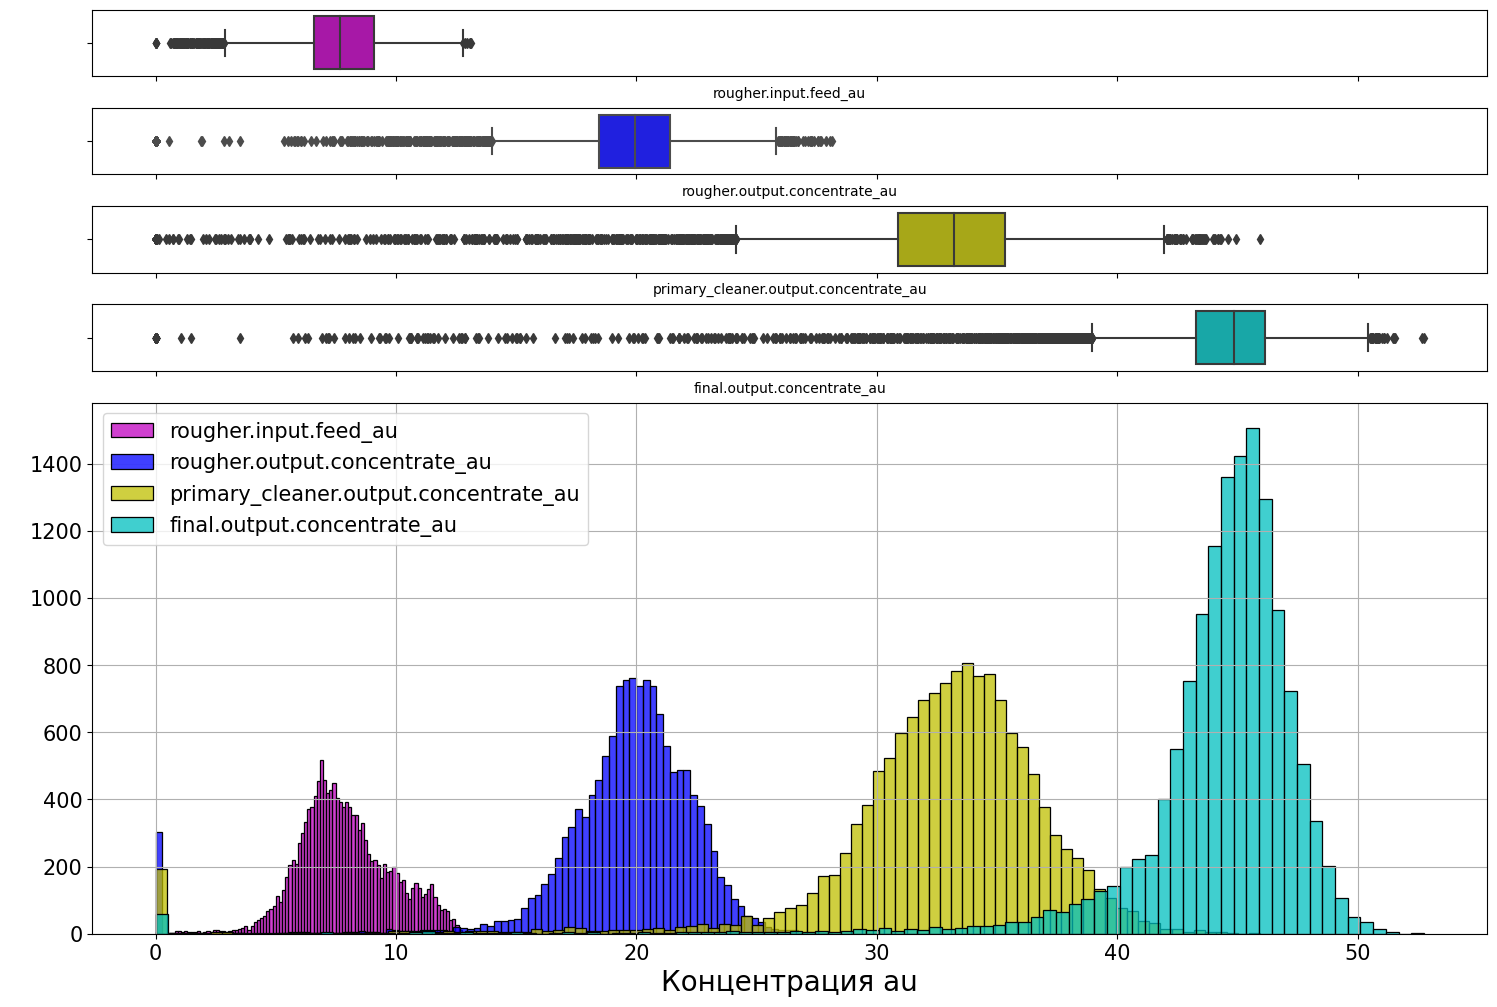

In [24]:
concentrate('au')

**Вывод:** 

Концентрация золота после флотации имеет более широкое распределение. Появилось большое кол-во выбросов. Среднее значение концентрации возрасло примерно в 1.7 раз. На этапе очистки распределение схожее, но смещено вправо, что говорит об увеличившихся значениях концентрации продукта. На финальном этапе распределение становится еще более узкое, при еще большем кол-ве выбросов. Всё это говорит о том, что качество выходного продукта значительно возросло, золото становится чище.

### 3.1.2 Ag

Этап  Медиана  Среднее     Диапазон
0  rougher.input.feed_a     8.16     8.58  0.01 - 14.6
1               rougher    11.75    11.77  0.0 - 21.73
2       primary_cleaner     8.23     8.20  0.0 - 16.08
3                 final     4.99     5.14   0.0 - 16.0

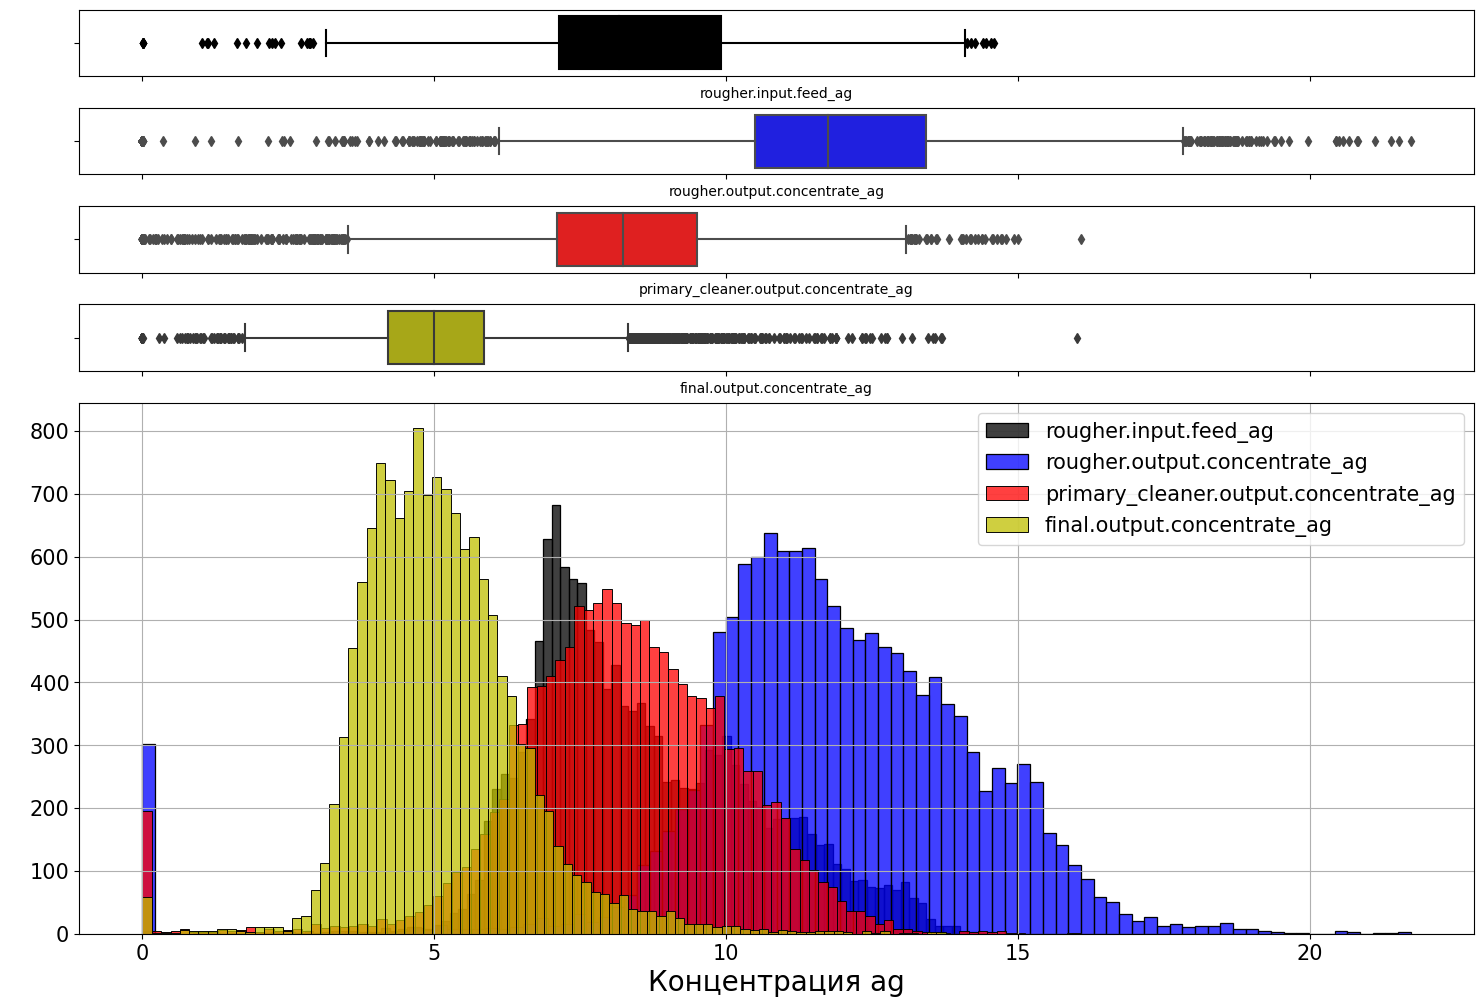

In [25]:
concentrate('ag')

**Вывод:** 

В случае с серебром ситуация обратная. На каждом этапе после выделения продукта, содержание серебра в руде уменьшается примерно в 1.5 раза. В тоже время распределение сужается, что говорит о более качественной очистке с каждым следующим этапом.

### 3.1.3 Pb

Этап  Медиана  Среднее     Диапазон
0  rougher.input.feed_p     3.43     3.53  0.01 - 7.14
1               rougher     7.76     7.66  0.0 - 13.62
2       primary_cleaner     9.93     9.58  0.0 - 17.08
3                 final    10.30    10.13  0.0 - 17.03

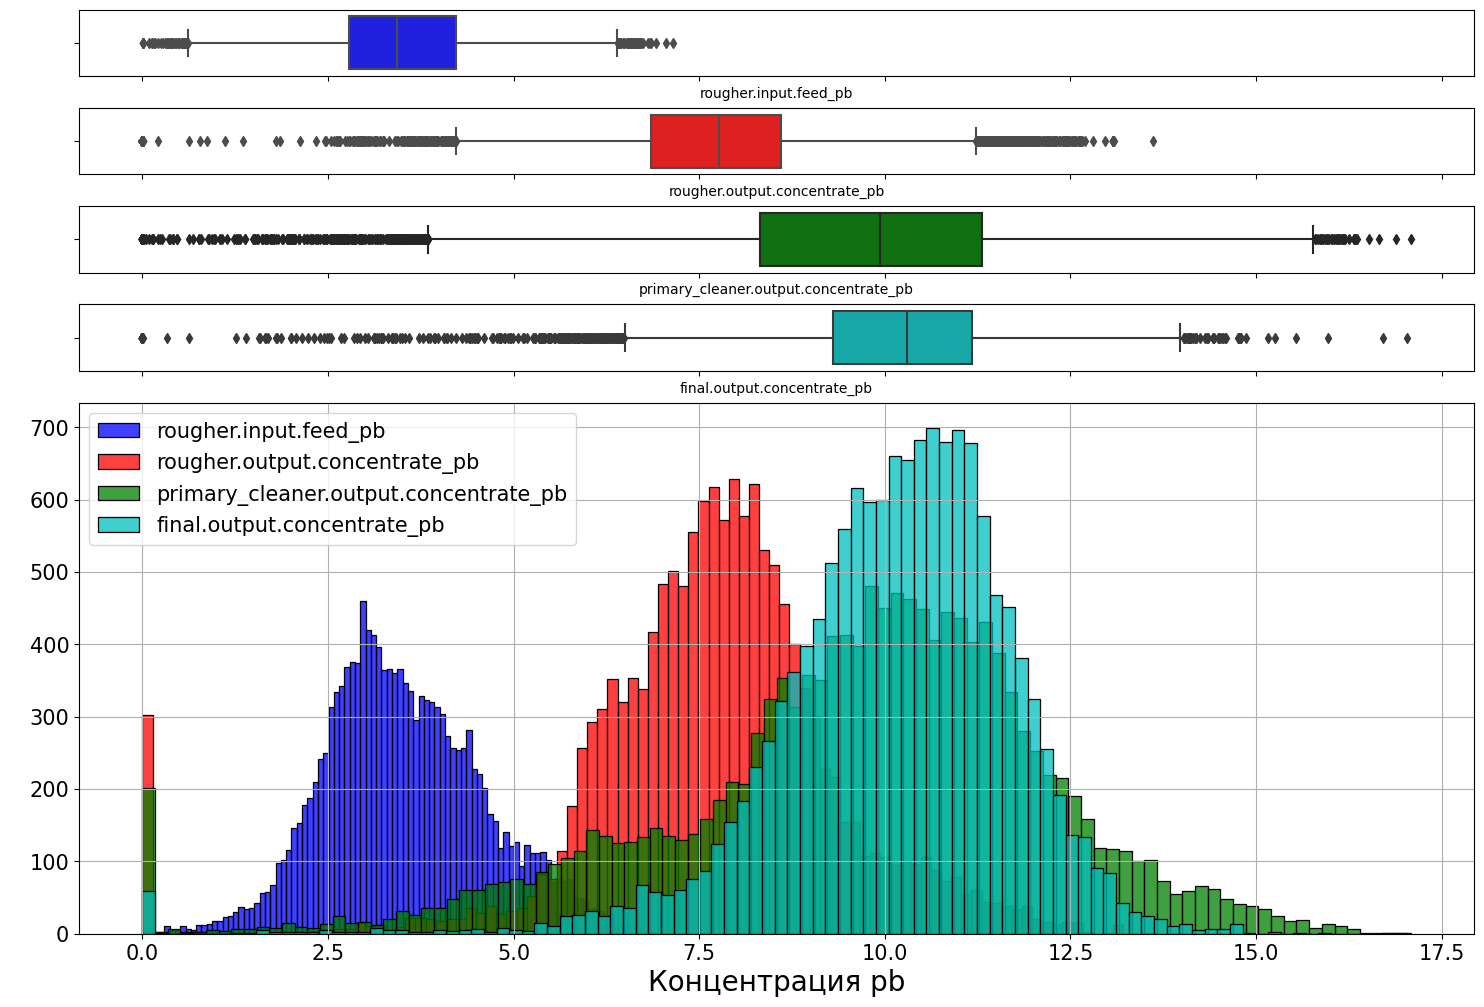

In [26]:
concentrate('pb')

**Вывод:**

Концентрация свинца значительно увеличивается после выделения продукта. Характеризуется примерно равными состояниями на финальном этапе и этапе первичной очистки. На этапе флотации средняя концентрация свинца была примерно на треть меньше.

На всех трех графиках есть нулевые значения. Возможно, это вызвано ошибками в данных, например из-за сбоя в оборудовании. Но я не знаком с технолгическим процессом обработки золота, поэтому не могу сделать однозначный вывод о том, что нулевых значений концентрации быть не должно. Поэтому удалять объекты на данном этапе исследования считаю некорректным. Далее посмотрим на суммарные распределения и уже от этого сделаем вывод.

## 3.2 Сравнение распределений размеров гранул сырья на обучающей и тестовой выборках

Размер гранул сырья обозначается *feed_size*. В данных есть 2 таких признака - `primary_cleaner.input.feed_size` и `rougher.input.feed_size`. Сравним их по гистограмме распределения:

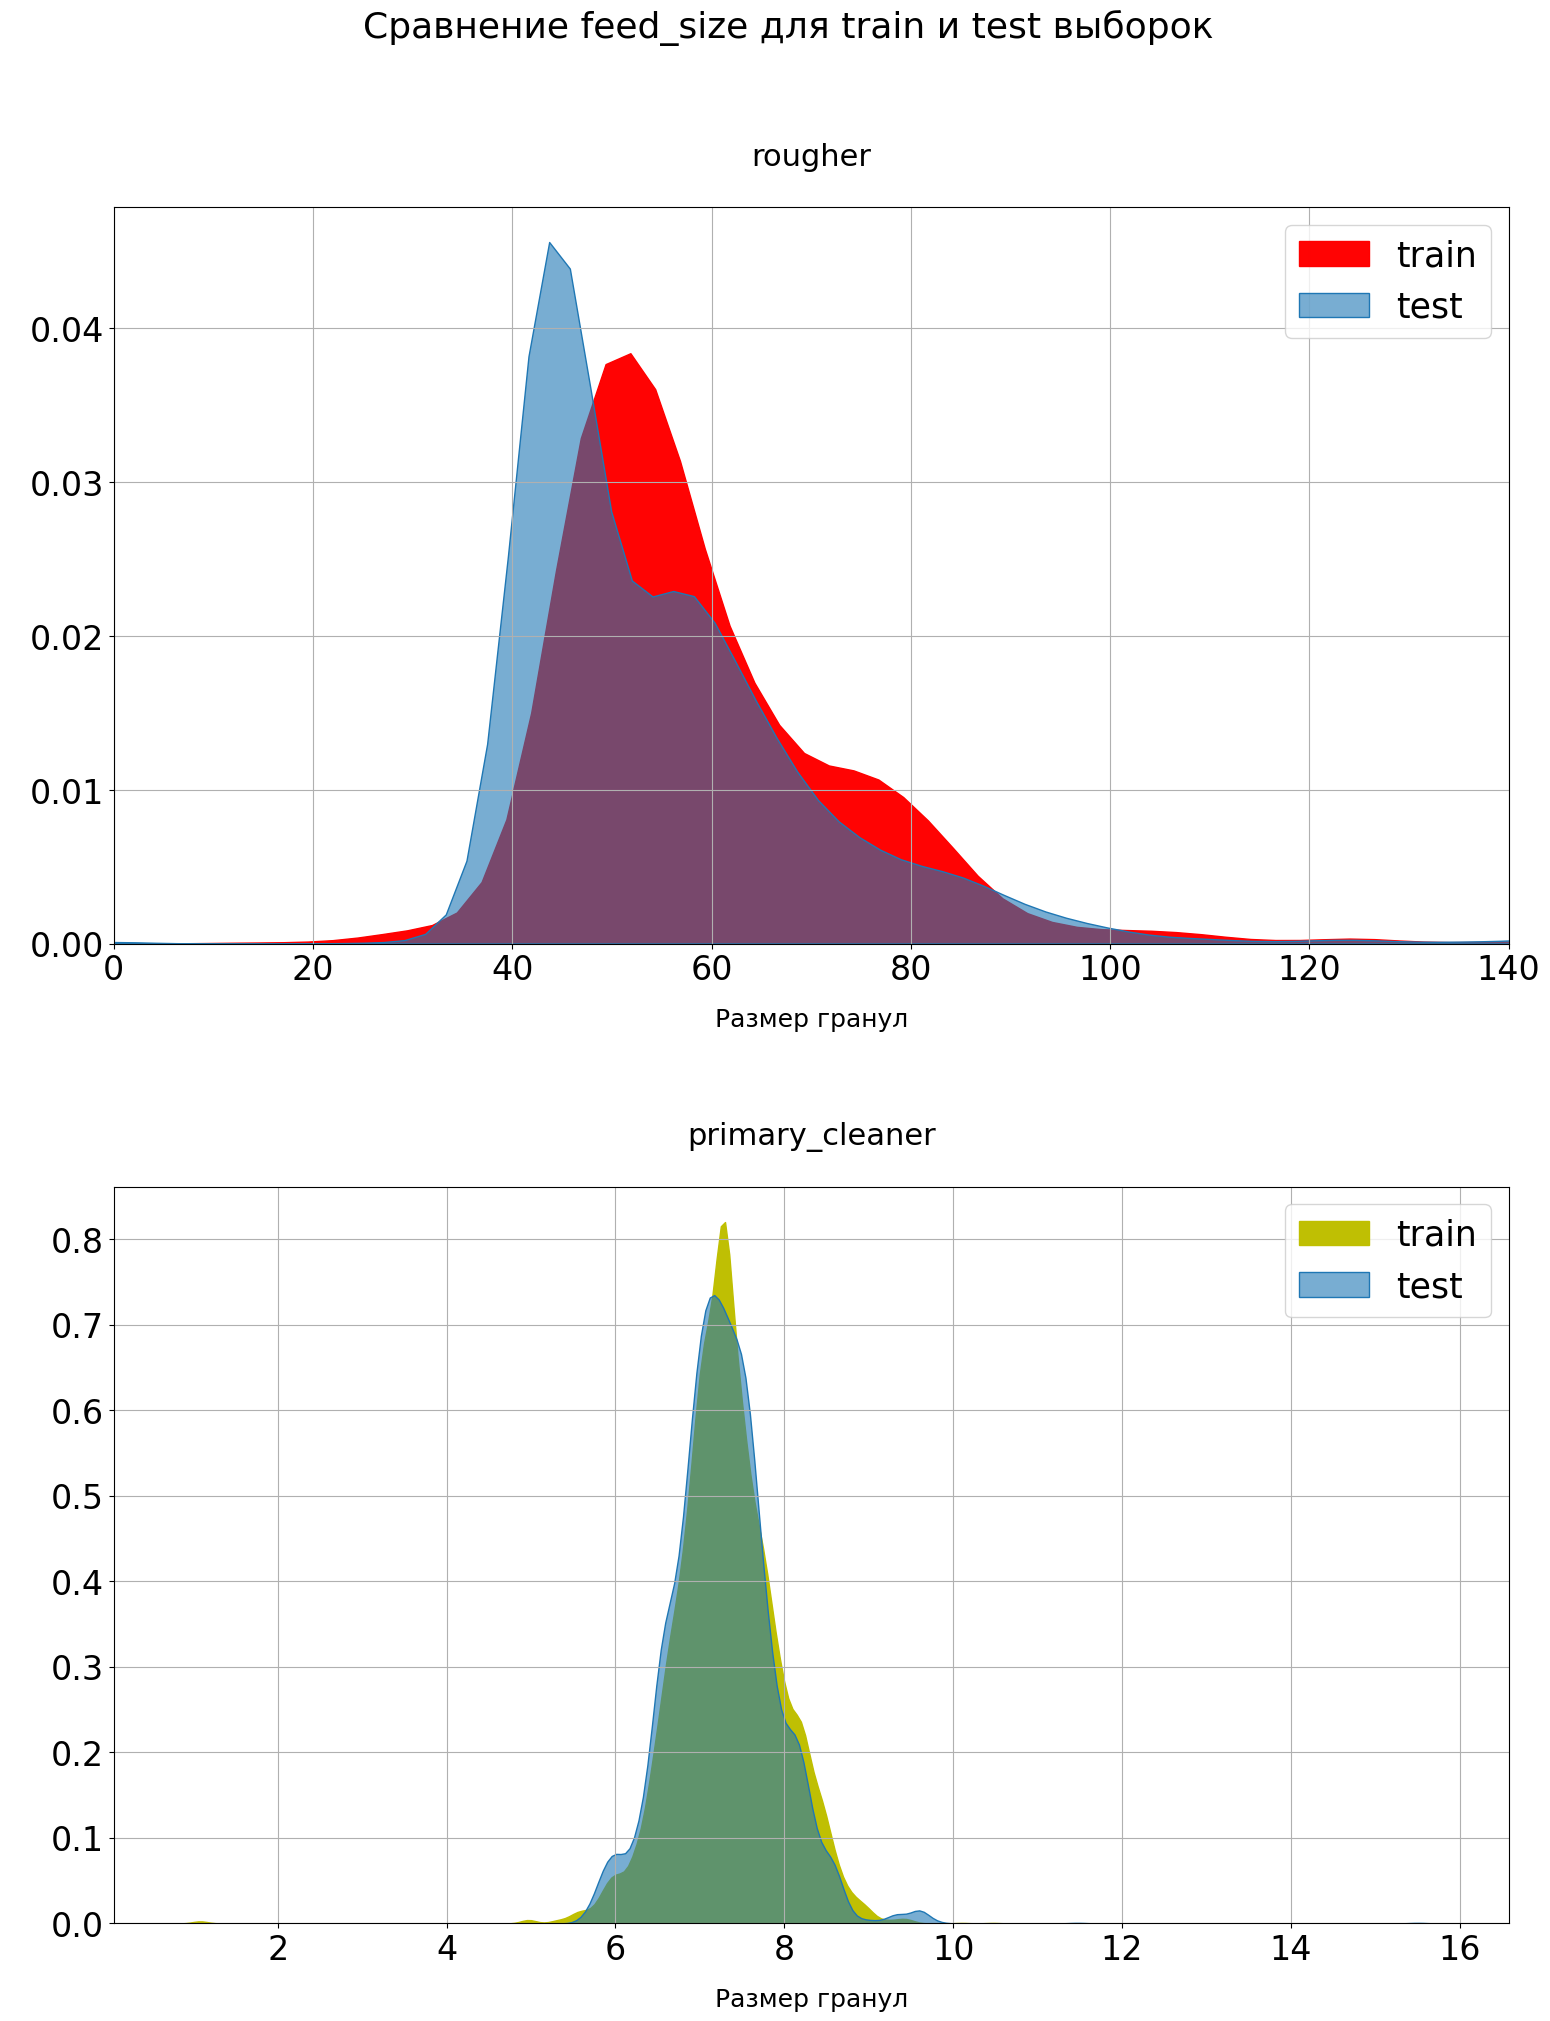

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(18, 22))

fig.suptitle('Сравнение feed_size для train и test выборок', fontsize=26)
fig.subplots_adjust(top=0.89, hspace=0.33)



sns.kdeplot(train['rougher.input.feed_size'], 
            color='r',
            fill=True,
            alpha=0.99,
            ax=ax[0])

sns.kdeplot(test['rougher.input.feed_size'],
            fill=True,
            alpha=0.6,
            ax=ax[0])

ax[0].set_title('rougher\n', fontsize=22)
ax[0].set_xlim([0, 140])



# график primary_cleaner
sns.kdeplot(train['primary_cleaner.input.feed_size'], 
            color='y',
            fill=True,
            alpha=0.99,
            ax=ax[1])

sns.kdeplot(test['primary_cleaner.input.feed_size'],
            fill=True,
            alpha=0.6,
            ax=ax[1],)

ax[1].set_title('primary_cleaner\n', fontsize=22)


# установка параметов для обоих графиков в цикле
for a in ax:
    a.legend(['train', 'test'], fontsize=25)
    a.set_xlabel('Размер гранул', fontsize=18, labelpad=15)
    a.set_ylabel(' ')
    a.tick_params(axis='x', labelsize=24)
    a.tick_params(axis='y', labelsize=24) 
    a.grid('on')
    

plt.show()

**Вывод:**

Все выборки имеют распределение близкое к нормальному. Друг от друга распределения сильно не отличаются, за исключением выделяющегося большого кол-ва значений 40-45 test выборки на этапе флотации.

## 3.3 Исследование суммарной концентрации всех веществ на разных стадиях

In [28]:
def concentrate_sum(row):
    '''Функция построения графиков для анализа'''
    
    result = sum([train[f'{row}_{i}'] for i in ['au', 'ag', 'pb', 'sol']])
    
    fig, ax = plt.subplots(figsize=(16, 6))
    fig.suptitle(f'Суммарная концентрация {row}', fontsize=20)
    
    sns.histplot(result,
        bins=100, 
        color=np.random.choice(color))
    
    ax.grid('on')
    ax.set_ylabel(' ')
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    
    return result

### 3.3.1 Сырье (feed)

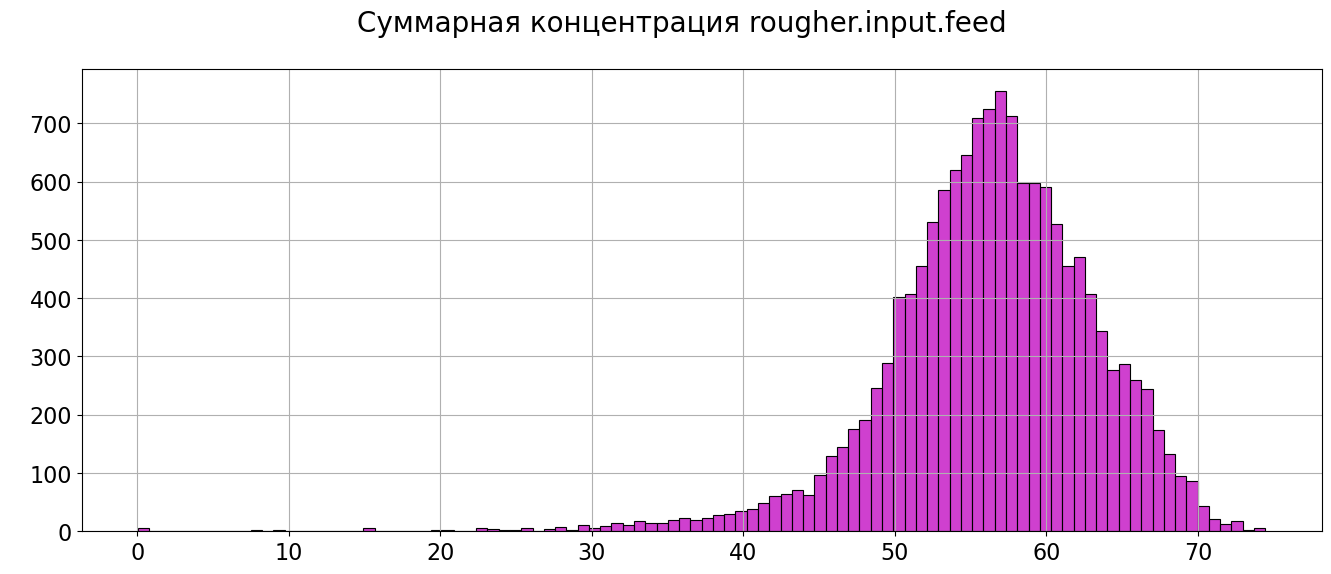

In [29]:
rougher_input_feed_sum = concentrate_sum('rougher.input.feed')

### 3.3.2 Черновой концентрат (rougher concentrate)

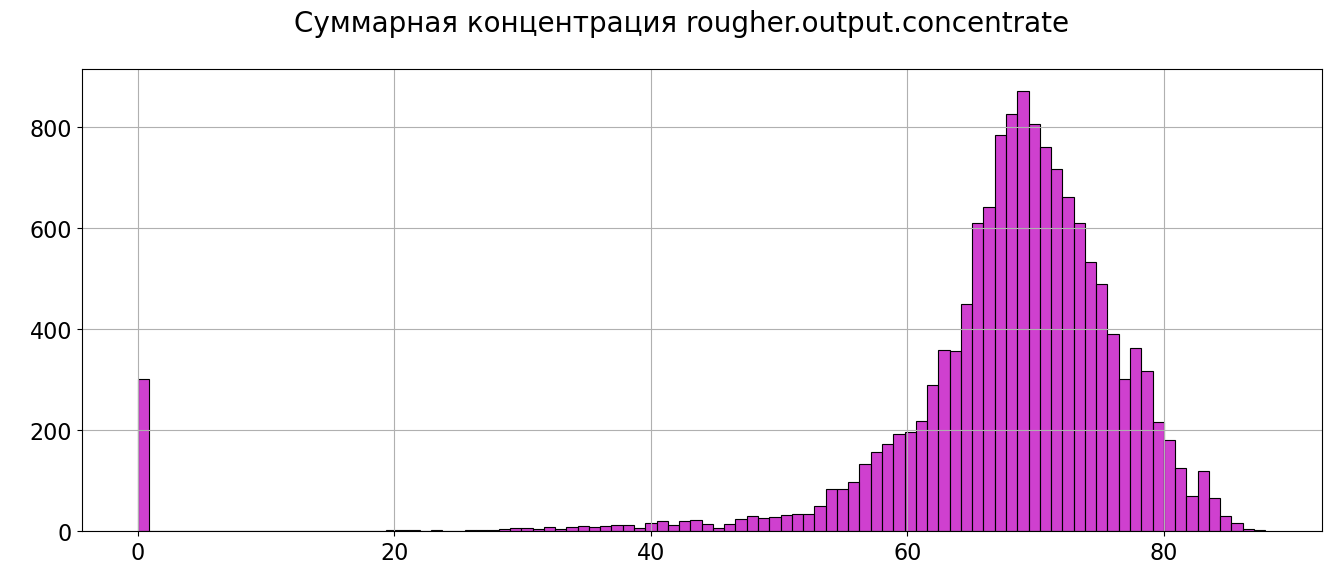

In [30]:
rougher_output_concentrate_sum = concentrate_sum('rougher.output.concentrate')

### 3.3.3 Финальный концентрат (final concentrate)

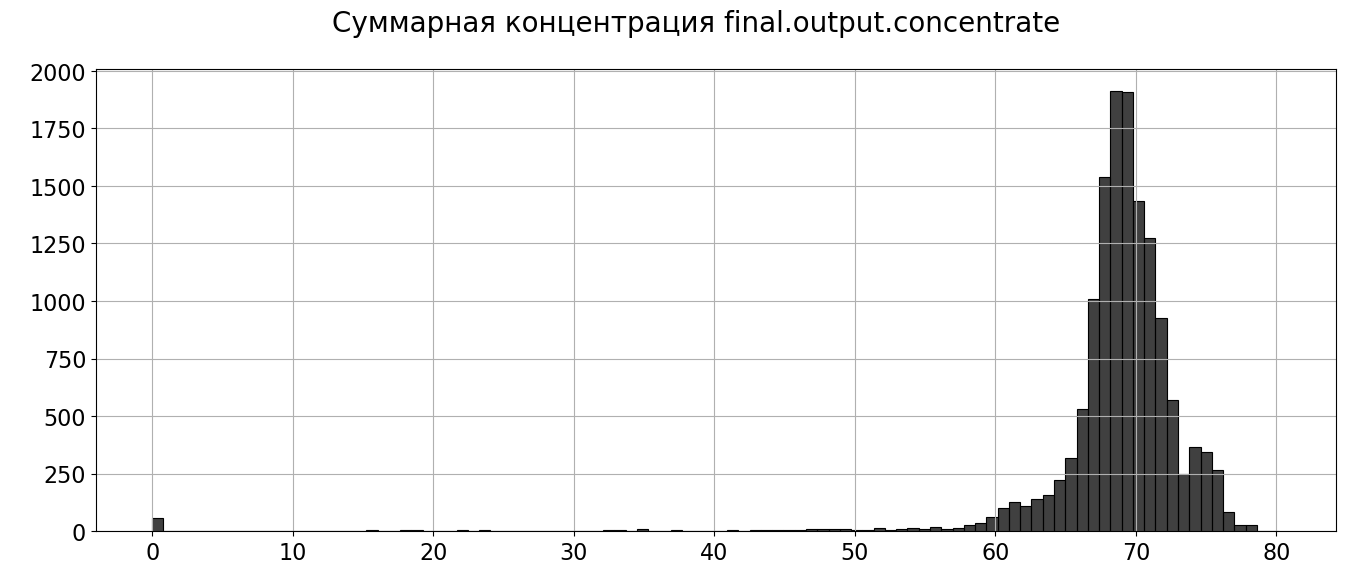

In [31]:
final_output_concentrate_sum = concentrate_sum('final.output.concentrate')

На гистограммах заметны нулевые суммарные значения. На этом этапе я всё же предположу, что это ошибочные данные. Удалим их из тренировочной выборки:

In [32]:
train.shape     # исходный размер

(14143, 87)

In [33]:
for i in [ rougher_input_feed_sum, 
           rougher_output_concentrate_sum, 
           final_output_concentrate_sum ]:
    
    train.drop(labels=i[i == 0].index, inplace=True, errors='ignore')
    
train.shape    # размер после удаления

(13789, 87)

**Вывод:** 

Исследована суммарная концентрация всех веществ на разных стадиях. Аномалии могут быть отдельно по каждому веществу, т.к. не всегда в руде есть крупицы золота, но суммарно - вряд ли т.к в руде хоть какие-то элементы, но будут. А если мы имеем ноль, значит большая вероятность неточности в измерениях. Поэтому обучающую выборку очистили от таких аномалий. После удаления нулей датасет уменьшился еще на 354 объекта. Гистограммы показывают, что с каждым следующим этапом обработки распределение суммарной концентрации веществ сужается, а амплитуда значений растет.  

# 4 Построение и обучение модели


На этом этапе обучим различные модели и оценим их качество кросс-валидацией.

## 4.1 Подготовка к обучению

<h3>Функции для вычисления sMAPE<span class="tocSkip"></span></h3>

sMAPE вычисляется так:

$$
sMAPE = \frac{1}{N} \sum\limits_{i=1}^N \frac{2 * |y_i - \stackrel{\land}{y_i}|}{|y_i| + |\stackrel{\land}{y_i}|} * 100\%
$$

где:  
$y_i$ - значение целевого признака для объекта с порядковым номером i в выборке, на которой измеряется качество;  
$\stackrel{\land}{y_i}$ - значение предсказания для объекта с порядковым номером i, например, в тестовой выборке;  
N - rоличество объектов в выборке;  

Необходимо спрогнозировать сразу две величины:

`rougher.output.recovery` - эффективность обогащения чернового концентрата;  
` final.output.recovery.` - эффективность обогащения финального концентрата. 

Итоговая метрика складывается из двух величин:


$$
sMAPE (итоговое) = 25\% * sMAPE(rougher) + 75\% * sMAPE(final)
$$

In [34]:
def smape(y_true, y_pred):
    '''Функция метрики sMAPE'''
    
    result = 0
    for t, p in zip(y_true, y_pred):
        result += (abs(t - p) / ((abs(t) + abs(p))/2) * 100)
    
    return result / len(y_true)

In [35]:
def total_smape(smape_rougher, smape_final):
    '''Функция итоговой sMAPE'''
    return round(0.25 * smape_rougher + 0.75 * smape_final, 2)

<h3>Модели:<span class="tocSkip"></span></h3>

In [36]:
linear_model = LinearRegression()      # линейной регрессии
rfc_model =  RandomForestRegressor()   # случайного леса

<h3>Метрики качества:<span class="tocSkip"></span></h3>

In [37]:
linear_smape = make_scorer(smape)                         # для регрессии
rfc_smape = make_scorer(smape, greater_is_better=False)   # для леса, т.к. нужна наименьшая метрика

## 4.2 rougher.output.recovery

### 4.2.1 Выделение признаков

Подготовим признаки для этапа флотации.

Согласно теории, во флотационную установку подаётся смесь золотосодержащей руды и после обогащения получается черновой концентрат, который в дальнейшем будет проходить этапы очистки. Тогда выделять признаки будем следующим образом: для `rougher` - все признаки сырья, т.е. только этапа флотации, для `final` - все остальные признаки, т.е. признаки всех этапов очистки.

In [38]:
# выборка признаков с меткой rougher, которые есть и в train и в test
rougher_features_lst = ( set(train.iloc[:, train.columns.str.contains('rougher')]) &
                         set(test.columns)  )

rougher_features_train = train[list(rougher_features_lst)]
rougher_target_train = train['rougher.output.recovery']

Посмотрим насколько зависимы между собой признаки, поскольку для линейных моделей это важно:

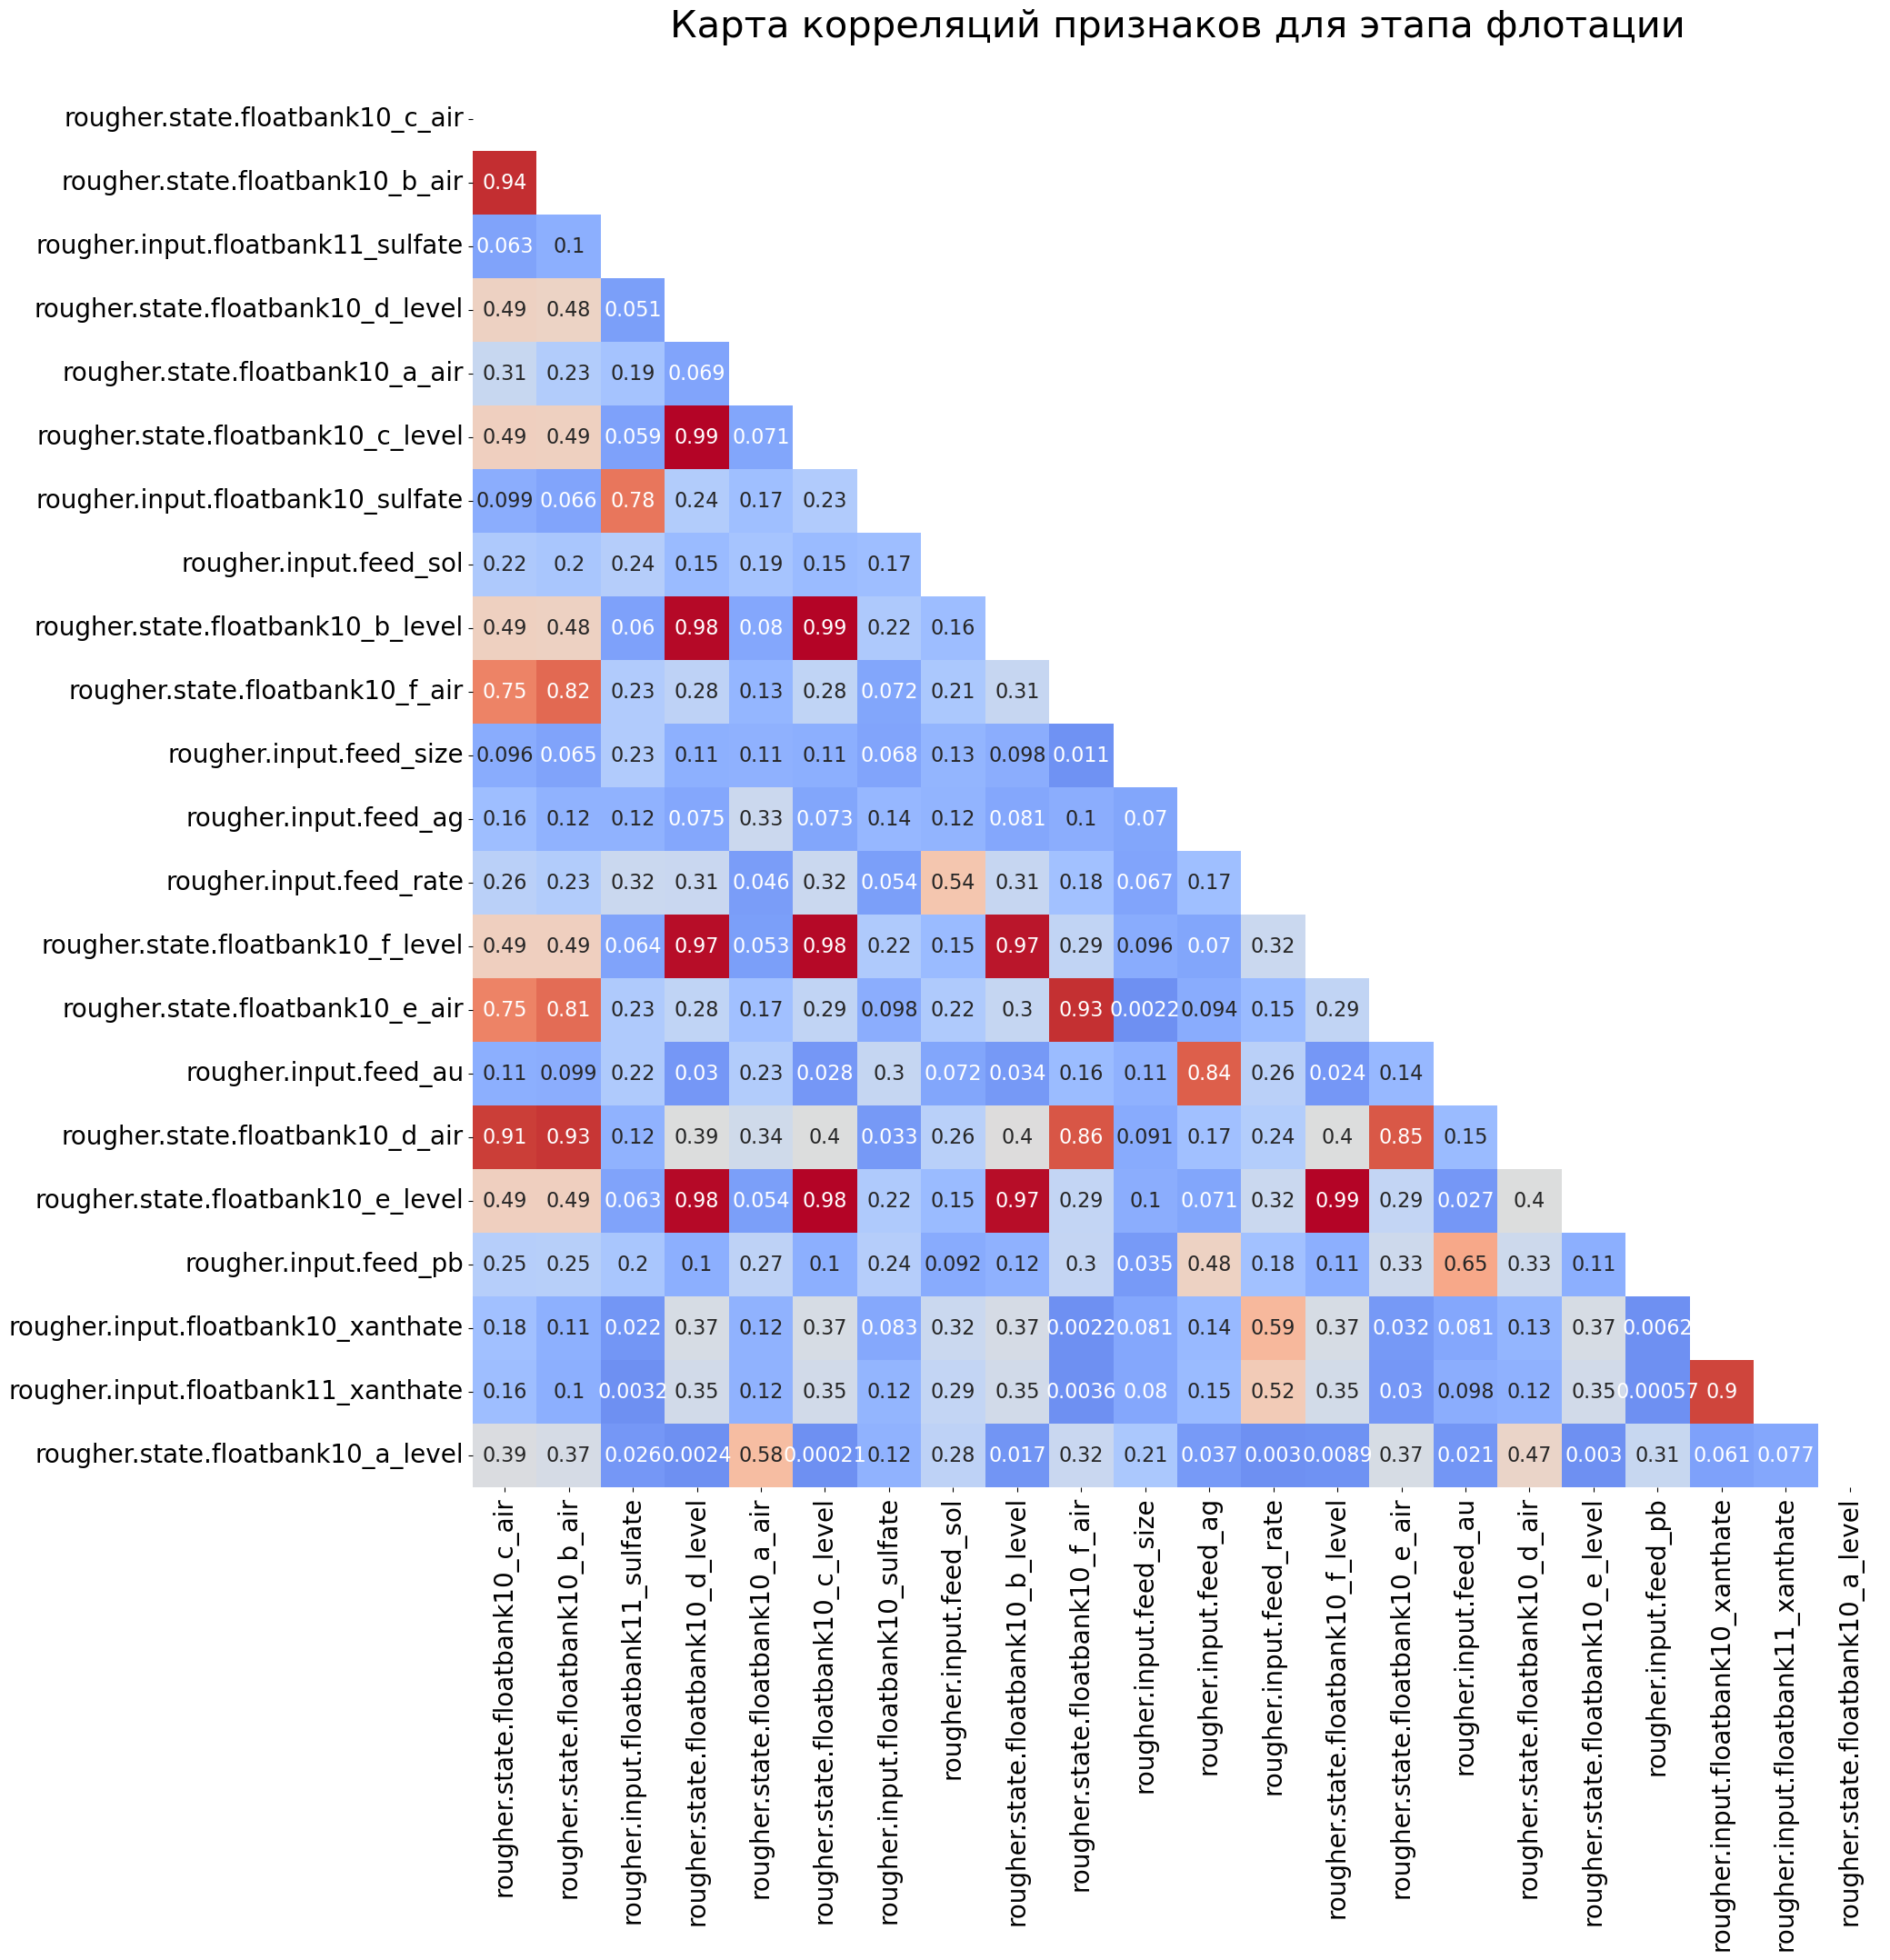

In [39]:
fig = plt.figure(figsize=(20, 20))

sns.heatmap( rougher_features_train.corr().abs(), 
             cmap="coolwarm", fmt='.2g', 
             cbar=False,
             center=0.4,
             annot=True, 
             annot_kws={'fontsize': 16},             
             mask=np.triu(rougher_features_train.corr()) )

plt.title('Карта корреляций признаков для этапа флотации'+ '\n', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Удалим из списка признаков признаки с большим кол-вом высоких корреляций и перезапишем обучающую выборку:

In [40]:
rougher_features_lst = rougher_features_lst - set([ 'rougher.state.floatbank10_d_level', 
                                                    'rougher.state.floatbank10_e_level',
                                                    'rougher.state.floatbank10_b_level', 
                                                    'rougher.state.floatbank10_d_air',
                                                    'rougher.state.floatbank10_d_air',
                                                    'rougher.state.floatbank10_f_air'])

rougher_features_train = train[list(rougher_features_lst)]

### 4.2.2 Линейная регрессия

In [41]:
scores = cross_val_score(linear_model, rougher_features_train, 
                         rougher_target_train, scoring=linear_smape, cv=5)

rougher_score = scores.mean()

print( '\nСреднее sMAPE модели линейной регрессии на этапе флотации =', 
        rougher_score.round(2) )


Среднее sMAPE модели линейной регрессии на этапе флотации = 6.67


### 4.2.3 Случайный лес

> Примечание: Полный перебор параметров был осуществлен мною заранее

In [42]:
%%time     

parametrs = { 'n_estimators': range(49, 50),       # 49
              'max_depth': range(5, 6),            # 5
              'min_samples_leaf': range(1, 2),     # 1
              'min_samples_split': range(3, 4),    # 3
              'random_state': [321] }


rougher_grid = GridSearchCV(rfc_model, parametrs, cv=5, scoring=rfc_smape)

rougher_grid.fit(rougher_features_train, rougher_target_train)

print( '\nСреднее sMAPE модели случайного леса на этапе флотации =',
        abs(rougher_grid.best_score_).round(2), '\n\n'  )


Среднее sMAPE модели случайного леса на этапе флотации = 6.54 


CPU times: total: 26.5 s
Wall time: 26 s


In [43]:
# лучшие параметры модели

rougher_grid.best_params_

{'max_depth': 5,
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 49,
 'random_state': 321}

**Вывод:** 

Для признака `rougher.output.recovery` наилучшее качество модели по метрике sMAPE показала модель случайного леса.

#### Визуализация важности фичей и качества выбранной модели

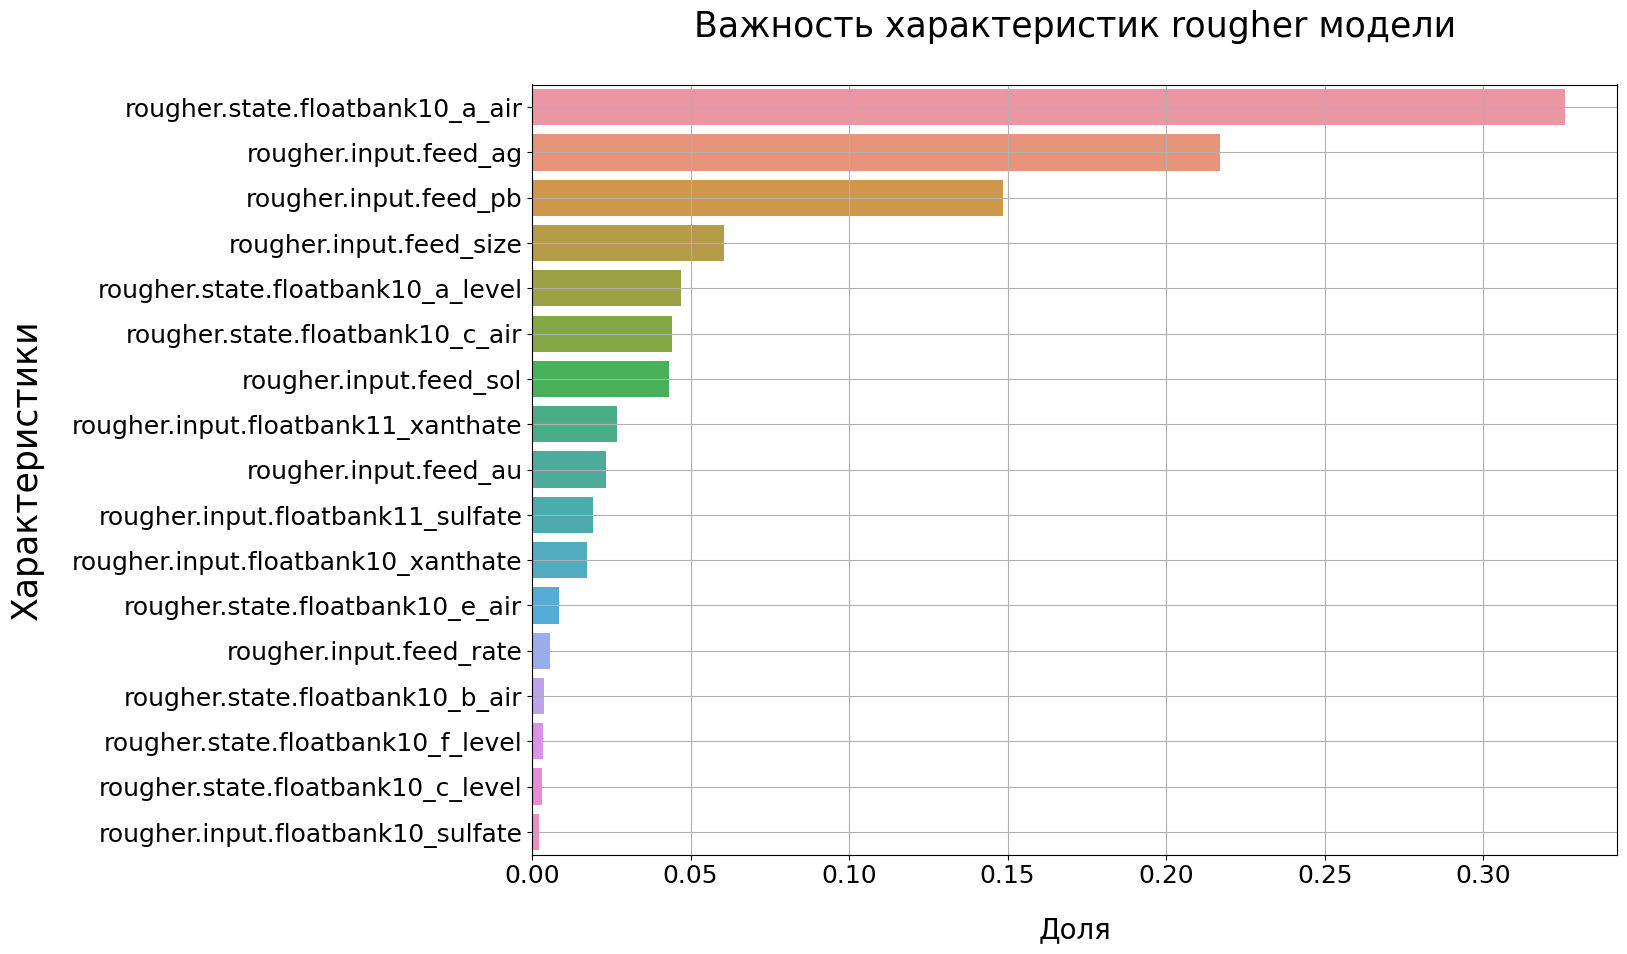

In [61]:
feature_importances = pd.Series(rougher_grid.best_estimator_.feature_importances_, rougher_features_train.columns)
feature_importances.sort_values(inplace=True, ascending=False)

plt.figure(figsize=(14, 10))
sns.barplot(x=feature_importances.values,
            y=feature_importances.index,            
            orient='h');
plt.title('Важность характеристик rougher модели\n', fontsize=25)
plt.xlabel('Доля', fontsize=20, labelpad=20)
plt.ylabel('Характеристики', fontsize=25, labelpad=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid('on')
plt.show()

## 4.3 final.output.recovery

### 4.3.1 Выделение признаков

По описаной выше методике выделим признаки для финального этапа:

In [45]:
# выборка всех признаков, кроме rougher, которые есть и в train и в test
final_features_lst = ( set(train.iloc[:, ~train.columns.str.contains('rougher')]) &
                       set(test.columns) -
                       set(['date']) )

final_features_train = train[list(final_features_lst)]

final_target_train = train['final.output.recovery']

Аналогичным образом проведем анализ признаков на мультиколлинеарность:

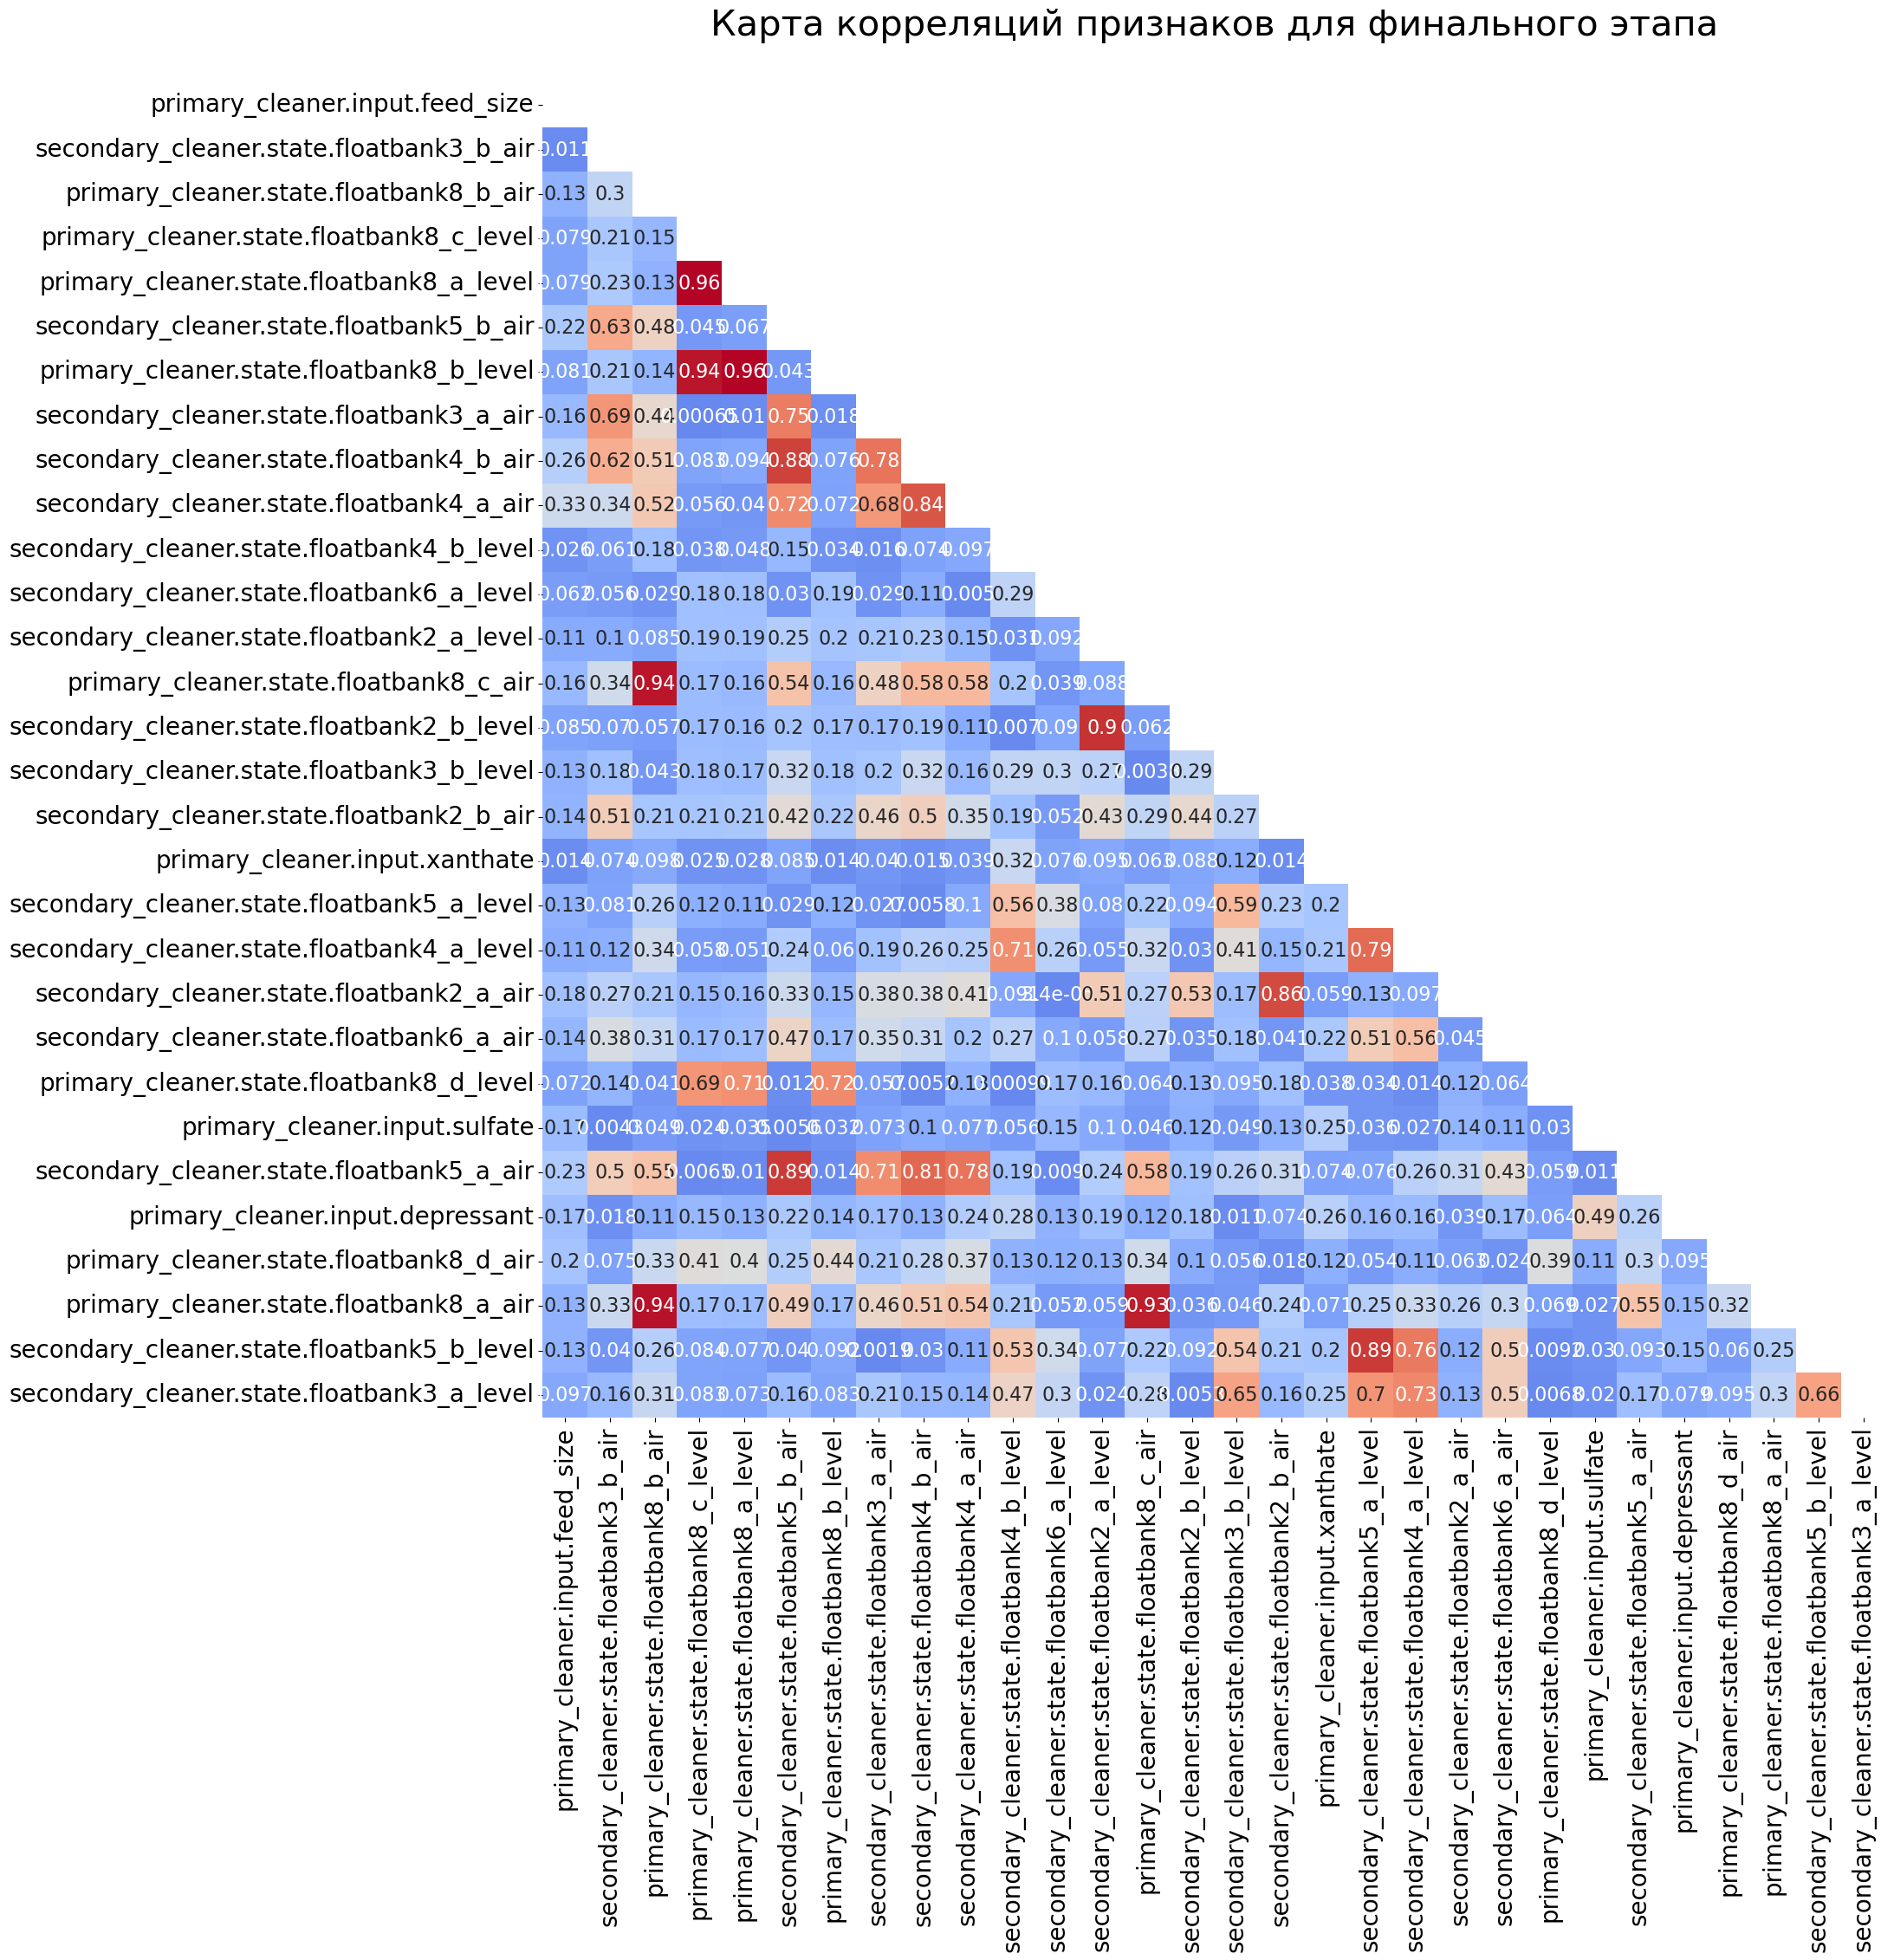

In [46]:
fig = plt.figure(figsize=(20, 20))

sns.heatmap( final_features_train.corr().abs(), 
             cmap="coolwarm", fmt='.2g', 
             cbar=False,
             center=0.4,
             annot=True, 
             annot_kws={'fontsize': 16},             
             mask=np.triu(final_features_train.corr()) 
               )

plt.title('Карта корреляций признаков для финального этапа'+ '\n', fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.show()

Удалим сильно коррелированные признаки:

In [47]:
final_features_lst = final_features_lst - set([ 'primary_cleaner.state.floatbank8_b_level',
                                                'secondary_cleaner.state.floatbank5_b_air',                                               
                                                'primary_cleaner.state.floatbank8_c_air',
                                                'primary_cleaner.state.floatbank8_a_air'  ])

final_features_train = train[list(final_features_lst)]

### 4.3.2 Линейная регрессия

In [48]:
scores = cross_val_score(linear_model, final_features_train, 
                         final_target_train, scoring=linear_smape, cv=5)

final_score = scores.mean()

print( '\nСреднее sMAPE модели линейной регрессии на финальном этапе =', 
        final_score.round(2) )


Среднее sMAPE модели линейной регрессии на финальном этапе = 9.96


### 4.3.3 Случайный лес

Аналогично, заранее перебрал диапазон параметров, а в функцию по итогу занес наилучшие с наименьшим диапазоном.

In [49]:
%%time     

parametrs = { 'n_estimators': range(6, 7),        # 7
              'max_depth': range(1, 2),           # 1
              'min_samples_leaf': range(1, 2),    # 1
              'min_samples_split': range(2, 3),   # 2
              'random_state': [12] }

final_grid = GridSearchCV(rfc_model, parametrs, cv=5, scoring=rfc_smape)

final_grid.fit(final_features_train, final_target_train)

print( '\nСреднее sMAPE модели случайного леса на финальном этапе =',
        abs(final_grid.best_score_).round(2), '\n\n'  )   # 9.93


Среднее sMAPE модели случайного леса на финальном этапе = 9.93 


CPU times: total: 1.94 s
Wall time: 1.12 s


In [50]:
# лучшие параметры модели

final_grid.best_params_

{'max_depth': 1,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 6,
 'random_state': 12}

**Вывод:** 

Для признака `final.output.recovery` наилучшее качество модели по метрике sMAPE так же показала модель случайного леса.

#### Визуализация важности фичей и качества выбранной модели

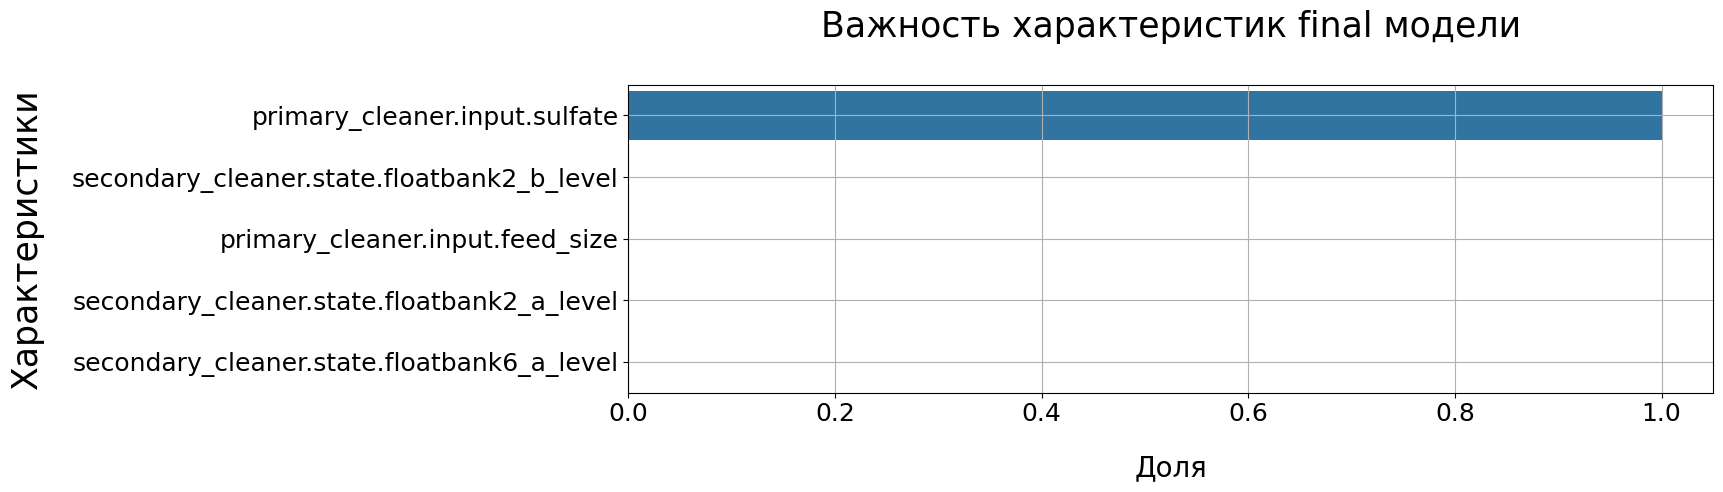

In [62]:
feature_importances = pd.Series(final_grid.best_estimator_.feature_importances_, final_features_train.columns)
feature_importances.sort_values(inplace=True, ascending=False)

plt.figure(figsize=(14, 4))
sns.barplot(x=feature_importances.values[:5],
            y=feature_importances.index[:5],            
            orient='h');
plt.title('Важность характеристик final модели\n', fontsize=25)
plt.xlabel('Доля', fontsize=20, labelpad=20)
plt.ylabel('Характеристики', fontsize=25, labelpad=20)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid('on')
plt.show()

# 5 Тестировние моделей

## 5.1 rougher.output.recovery

Т.к. в тестовой выборке нет целевого признака, возьмем его из выборки full:

In [52]:
test = test.merge(full[['rougher.output.recovery', 'final.output.recovery', 'date']],
                         how='inner', on='date')

In [53]:
# признаки

rougher_features_test = test[list(rougher_features_lst)]

rougher_target_test = test['rougher.output.recovery']

In [54]:
rougher_pred = rougher_grid.predict(rougher_features_test)

smape_rougher = smape(rougher_target_test, rougher_pred).round(2)

print('\nsMAPE этапа флотации на тестовой выборке =', smape_rougher) 


sMAPE этапа флотации на тестовой выборке = 8.11


## 5.2 final.output.recovery

Целевой признак так же возьмем из выборки full:

In [55]:
final_features_test = test[list(final_features_lst)]

final_target_test = test['final.output.recovery']

In [56]:
final_pred = final_grid.predict(final_features_test)

smape_final = smape(final_target_test, final_pred).round(2)

print('\nsMAPE финального этапа на тестовой выборке =', smape_final) 


sMAPE финального этапа на тестовой выборке = 8.79


## 5.3 Итоговая sMAPE

In [57]:
print('\nИтоговая sMAPE =', total_smape(smape_rougher, smape_final))


Итоговая sMAPE = 8.62


## 5.4 Сравнение с константной моделью

Посмотрим что предскажет дамми модель:

In [58]:
dummy = DummyRegressor(strategy='median').fit(rougher_features_train, rougher_target_train)
predict_dummy = dummy.predict(rougher_features_test)
smape_rougher_dummy = smape(rougher_target_test, predict_dummy).round(2)

print('\nsMAPE dummy модели этапа флотации на тестовой выборке =', smape_rougher_dummy) 


sMAPE dummy модели этапа флотации на тестовой выборке = 8.38


In [59]:
dummy = DummyRegressor(strategy='median').fit(final_features_train, final_target_train)
predict_dummy = dummy.predict(final_features_train)
smape_final_dummy = smape(final_target_train, predict_dummy).round(2)

print('\nsMAPE dummy модели финального этапа на тестовой выборке =', smape_final_dummy) 


sMAPE dummy модели финального этапа на тестовой выборке = 10.17


In [60]:
print('\nИтоговая sMAPE =', total_smape(smape_rougher_dummy, smape_final_dummy))


Итоговая sMAPE = 9.72


**Вывод:**

Судя по метрике константной модели наша построенная модель прошла проверку на адекватность.

<div class="alert alert-warning" role="alert"; style="border:groove rgb(57,136,235) 5px; padding: 40px">

<h1 align="center", style="margin-bottom: 15px">ВЫВОДЫ</h1>

## Итоги работы:
<p style="margin-bottom: 20px"></p> 
<div align="justify">$\;\;\;\;\;\;\;\;$В результате работы была разработана модель для предсказания коэффициента восстановления золота из золотосодержащей руды на основании данных по параметрами добычи и очистки, предоставленных компанией "Цифра".
</div>

Модель представляет из себя 2 различных модели на базе <i>RandomForestRegressor</i> - одна для этапа флотации (`rougher`), вторая для финального этапа (`final`).

Метрики моделей на тестовой выборке:

sMAPE этапа флотации = 8.11  
sMAPE финального этапа = 8.79

**Итоговая sMAPE = 8.62**


## Отчет о выполнении проекта:
<p style="margin-bottom: 30px"></p>
1. Предварительный обзор данных показал, что:

+ данные состоят из 3 таблиц разного размера;
+ кол-во признаков - 87;
+ все признаки, кроме даты - числовые;
+ пропуски имеются во всех 3 датасетах;
+ явные дубликаты отсутствуют.
+ в тренировочных данных присутствует около 1.5% коррелирующих признаков.  
    
<p style="margin-bottom: 30px"></p>
2. В ходе предобработки было выполнено:

+ обработаны все пропуски в тренировочной выборке;
  + удалены объекты, в которых пропущено более 4 признаков;
  + удалены объекты с пропусками в столбцах, в которых доля пропусков меньше 0.5%;
  + оставшиеся пропуски были заменены на смежное предыдущее значение.

+ удалены все пропуски в тестовой выборке.
    
<p style="margin-bottom: 30px"></p>
3. В ходе исследовательского анализа было выявлено:

+ концентрация золота после флотации имеет более широкое распределение с большим кол-вом выбросов. Среднее значение концентрации возрастает примерно в 1.7 раз. На этапе очистки распределение схожее, но смещено вправо, что говорит об увеличившихся значениях концентрации продукта. На финальном этапе распределение становится еще более узкое, при еще большем кол-ве выбросов. Всё это говорит о том, что качество выходного продукта значительно возросло, золото становится чище.
+ в случае с серебром ситуация обратная. На каждом этапе содержание серебра в руде уменьшается примерно в 1.5 раза. В тоже время распределение сужается, что говорит о более качественной очистке с каждым следующим этапом. Кол-во нулевых значений примерно схожее с золотом;
+ концентрация свинца характеризуется примерно равными состояниями на финальном этапе и этапе первичной очистки. На этапе флотации средняя концентрация свинца была примерно на треть меньше;
+ распределение размеров гранул сырья на обучающей и тестовой выборках близкое к нормальному. Друг от друга распределения сильно не отличаются, за исключением выделяющегося большого кол-ва значений 40-45 test выборки на этапе флотации;
+ с каждым следующим этапом обработки распределение суммарной концентрации веществ сужается, а амплитуда значений растет.

    
<p style="margin-bottom: 40px"></p>
4. Всего в ходе работы были протестированы следующие модели:

LR - LogisticRegression  
RFC - RandomForestClassifier

Для каждого этапа (`rougher` и `final`) создавалась своя модель.

Метрика sMAPE на тренировочной выборке на кросс-валидации:

LR - 6.67 для флотации и 9.96 для финального этапа;  
RFC - 6.54 для флотации и 9.93 для финального этапа.

В результате работы лучшей моделью оказалась модель случайного леса RFC.

Гиперпараметры итоговых моделей:

<table>
<tr>
  <th>Параметр</th>
  <th>Модель для rougher</th>
  <th>Модель для final</th>
</tr>
<tr>
  <td>max_depth</td>
  <td>5</td>
  <td>1</td>
</tr>    
<tr>
  <td>min_samples_leaf</td>
  <td>1</td>
  <td>1</td>
</tr>   
<tr>
  <td>min_samples_split</td>
  <td>3</td>
  <td>2</td>
</tr> 
<tr>
  <td>n_estimators</td>
  <td>49</td>
  <td>6</td>
</tr>
<tr>
  <td>random_state</td>
  <td>321</td>
  <td>12</td>
</tr>
</table>

<p style="margin-bottom: 30px"></p>
5. Визуализация важности характеристик 

Ниже представлены характеристики и доля их важности в %:

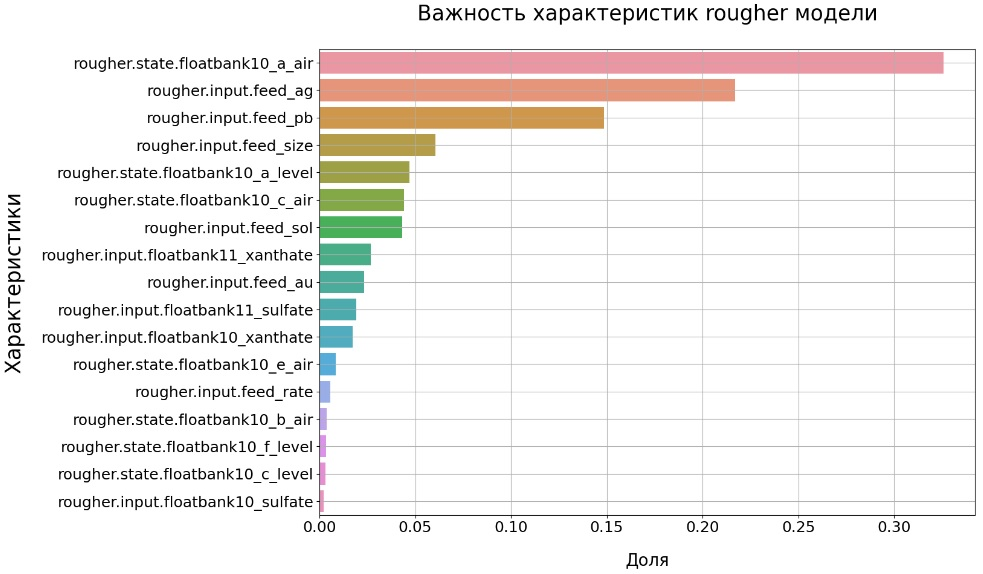

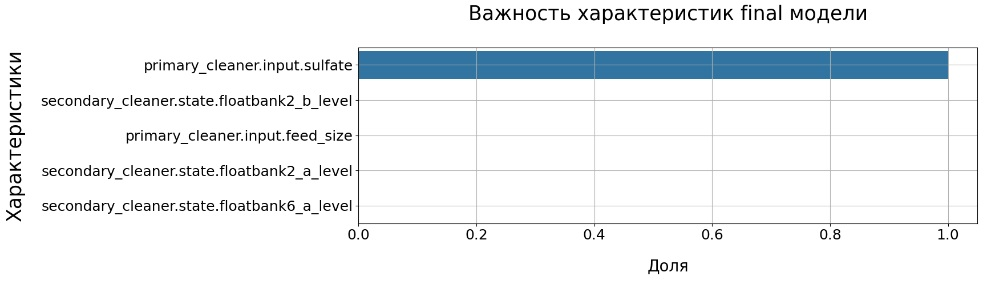
